# Phishing Detection Model Training with WandB

This notebook trains and evaluates three phishing detection models:
1. **TF-IDF + Logistic Regression** (baseline)
2. **Hybrid XGBoost** (text embeddings + engineered features)
3. **Hybrid MLP** (text embeddings + engineered features)

All experiments are tracked using Weights & Biases for reproducibility and comparison.

## 1. Install and Import Required Libraries

In [38]:
import os
import sys
import json
import pickle
from datetime import datetime
from pathlib import Path
import numpy as np
import polars as pl
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import wandb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
from sentence_transformers import SentenceTransformer
import xgboost as xgb
import optuna
from optuna.integration.wandb import WeightsAndBiasesCallback

import matplotlib.pyplot as plt
import seaborn as sns

# Add parent directory to path for imports
sys.path.append(str(Path.cwd().parent.parent))

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
print(f"Optuna version: {optuna.__version__}")

PyTorch version: 2.5.1+cu121
CUDA available: True
Device: cuda
Optuna version: 4.6.0


## 2. Configure WandB and Experiment Settings

In [42]:
wandb.login()

config = {
    "random_seed": 42,
    "train_split": 0.6,
    "test_split": 0.2,
    "external_split": 0.2,
    "data_source": "emails_v4.parquet",
    
    "numeric_features": [
        "sender_domain_entropy", "has_attachment",
        "spf_flag_missing", "dkim_flag_missing",
        "num_links", "subject_length", "body_length", "keyword_count", 
        "num_received_headers", "num_exclamation_marks", 
        "num_malicious_links"
    ],
    "embedding_model": "all-MiniLM-L6-v2",
    "embedding_dim": 384,
    
    # TF-IDF optimized params 
    "tfidf_max_features": 10000,
    "tfidf_ngram_range": (1, 1),
    "tfidf_min_df": 8,
    "tfidf_max_df": 0.95,
    "tfidf_threshold": 0.4,
    "lr_max_iter": 1000,
    "lr_C": 1.299304926078878,
    "lr_class_weight_ratio": 9.0,
    
    # XGBoost recall-optimized params 
    "xgb_max_depth": 8,
    "xgb_n_estimators": 350,
    "xgb_learning_rate": 0.02267537876243619,
    "xgb_min_child_weight": 5,
    "xgb_subsample": 0.95,
    "xgb_colsample_bytree": 0.85,
    "xgb_scale_pos_weight": 7.5,
    "xgb_threshold": 0.4,
    "xgb_early_stopping": 20,
    
    # MLP recall-optimized params
    "mlp_feature_hidden_dim": 64,
    "mlp_dropout": 0.5,
    "mlp_lr": 0.0028961603572682073,
    "mlp_weight_decay": 0.00011146976827416427,
    "mlp_epochs": 50,
    "mlp_batch_size": 128,
    "mlp_pos_weight": 8.5,
    "mlp_threshold": 0.4,
    "mlp_early_stopping": 10,
}


## 3. Load and Prepare Dataset

In [43]:
# Load dataset
print("Loading dataset...")
df = pl.read_parquet("../../emails_v6.parquet")
pl.Config.set_tbl_rows(-1)
print(df.select("source").unique())
print(f"Total records: {len(df):,}")
print(f"Columns: {df.columns}")

# Check class distribution
phishing_count = df.filter(pl.col("phishing") == 1).shape[0]
legit_count = df.filter(pl.col("phishing") == 0).shape[0]

print(f"\nClass distribution:")
print(f"  Phishing: {phishing_count:,} ({phishing_count/len(df)*100:.2f}%)")
print(f"  Legitimate: {legit_count:,} ({legit_count/len(df)*100:.2f}%)")

# Log to WandB
wandb.log({
    "total_records": len(df),
    "phishing_count": phishing_count,
    "legit_count": legit_count,
    "class_balance": phishing_count / len(df)
})

Loading dataset...
shape: (22, 1)
┌────────────────────────────┐
│ source                     │
│ ---                        │
│ str                        │
╞════════════════════════════╡
│ phishing-2015              │
│ phishing-2018              │
│ data/csv_misc/Assassin.csv │
│ phishing-2022              │
│ phishing-2024              │
│ data/csv_misc/TREC-07.csv  │
│ data/csv_misc/Ling.csv     │
│ mbox_andrunik.mbox         │
│ phishing-2020              │
│ phishing-2014              │
│ phishing-2019              │
│ phishing-2013              │
│ data/csv_misc/CEAS-08.csv  │
│ phishing-2017              │
│ mbox_gradzki.mbox          │
│ phishing-2021              │
│ data/csv_misc/TREC-06.csv  │
│ data/csv_misc/Enron.csv    │
│ data/csv_misc/TREC-05.csv  │
│ phishing-2016              │
│ phishing-2023              │
│ phishing-nigerian          │
└────────────────────────────┘
Total records: 212,113
Columns: ['source', 'phishing', 'spf_flag', 'dkim_flag', 'd_flag', 'num_rec

Error: You must call wandb.init() before wandb.log()

## 3.1. Dataset Distribution Analysis

DATASET SOURCE DISTRIBUTION
shape: (22, 4)
┌────────────────────────────┬───────┬────────────────┬────────────────┐
│ source                     ┆ count ┆ phishing_count ┆ phishing_ratio │
│ ---                        ┆ ---   ┆ ---            ┆ ---            │
│ str                        ┆ u32   ┆ u32            ┆ f64            │
╞════════════════════════════╪═══════╪════════════════╪════════════════╡
│ data/csv_misc/TREC-07.csv  ┆ 53164 ┆ 28862          ┆ 0.542886       │
│ data/csv_misc/TREC-05.csv  ┆ 49843 ┆ 18443          ┆ 0.370022       │
│ data/csv_misc/CEAS-08.csv  ┆ 38736 ┆ 21456          ┆ 0.553903       │
│ data/csv_misc/Enron.csv    ┆ 28799 ┆ 13244          ┆ 0.459877       │
│ data/csv_misc/TREC-06.csv  ┆ 15712 ┆ 3582           ┆ 0.227979       │
│ mbox_gradzki.mbox          ┆ 6373  ┆ 0              ┆ 0.0            │
│ data/csv_misc/Assassin.csv ┆ 5578  ┆ 1572           ┆ 0.281821       │
│ phishing-nigerian          ┆ 3901  ┆ 3901           ┆ 1.0            │
│ mbox_a

C:\Users\Latandu\AppData\Local\Temp\ipykernel_27584\4289937131.py:9: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("count"),


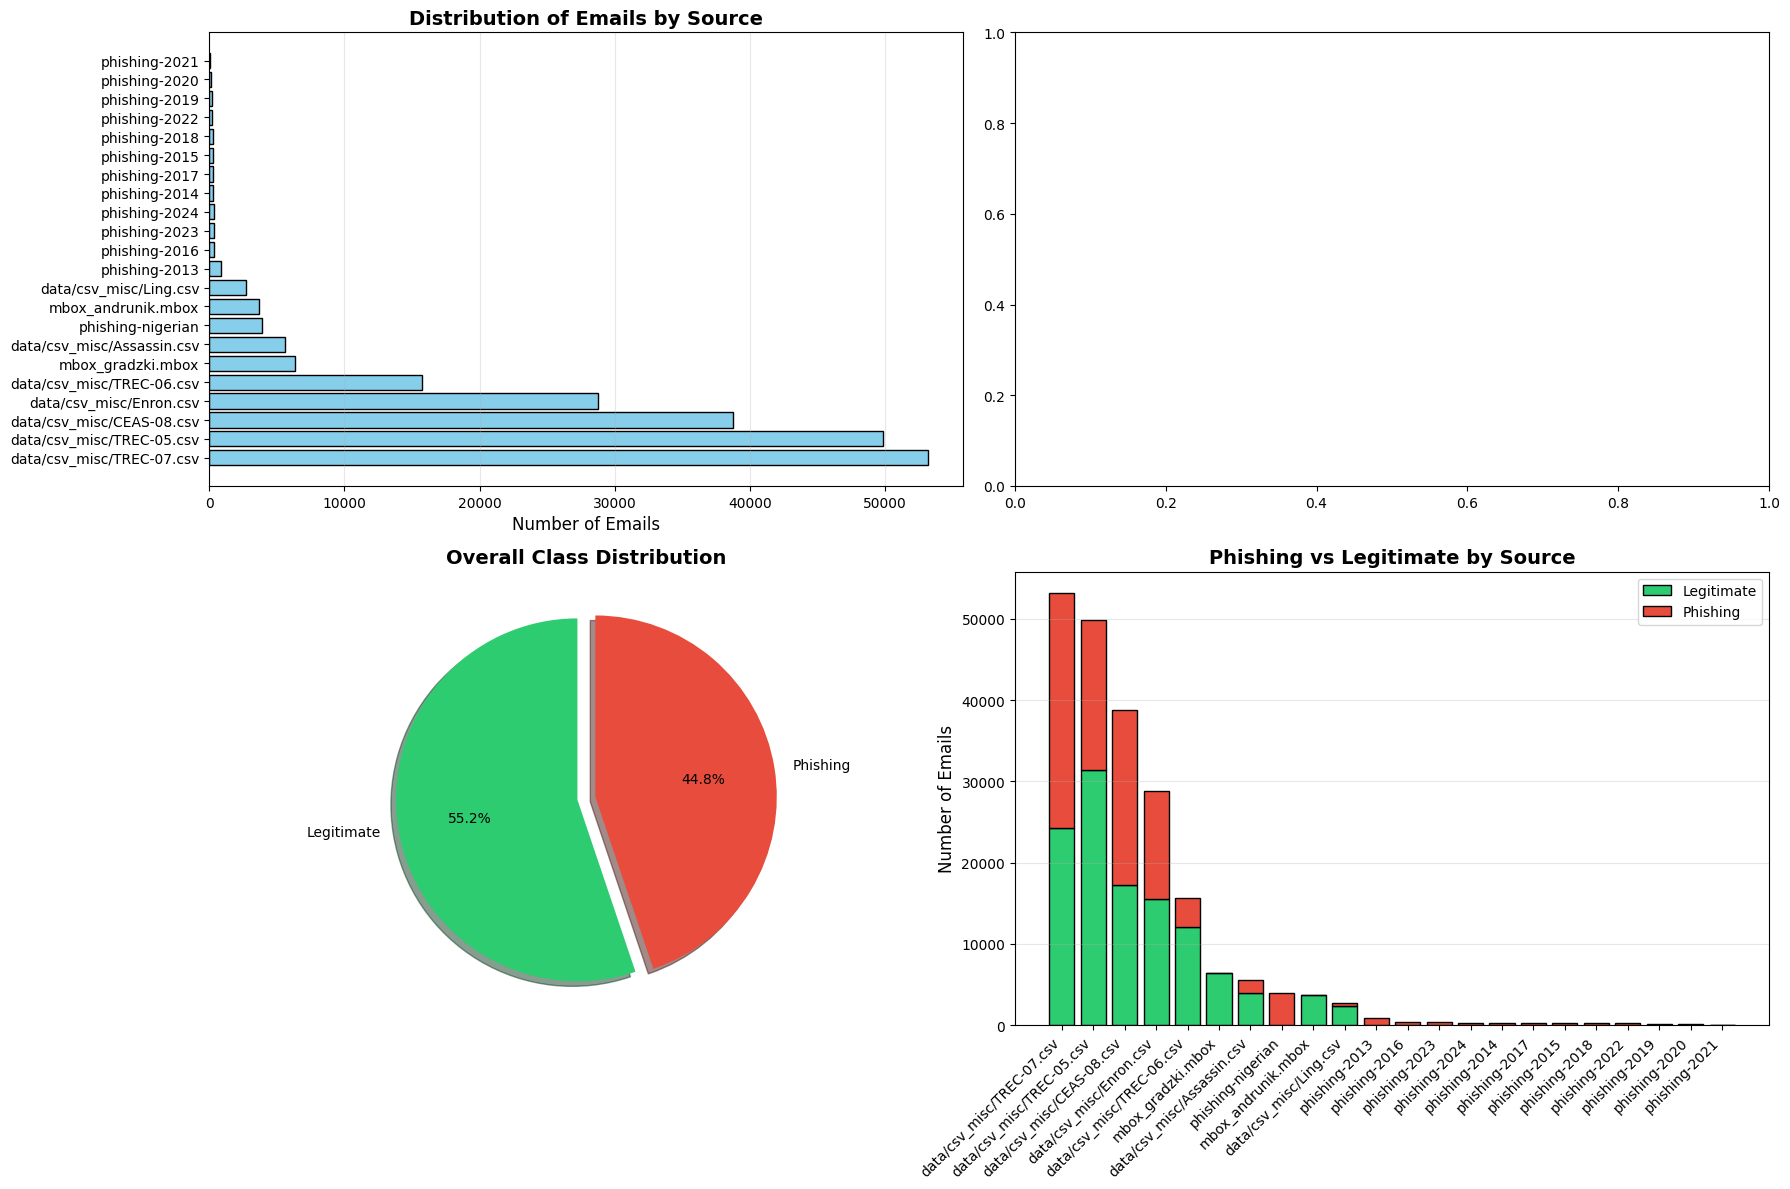

In [ ]:
# Dataset source distribution
df_pd = df.to_pandas()

# 1. Source Distribution
print("="*80)
print("DATASET SOURCE DISTRIBUTION")
print("="*80)
source_counts = df.group_by("source").agg([
    pl.count().alias("count"),
    pl.col("phishing").sum().alias("phishing_count"),
    pl.col("phishing").mean().alias("phishing_ratio")
]).sort("count", descending=True)

print(source_counts)

# Plot source distribution
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Source count
ax1 = axes[0, 0]
source_data = source_counts.to_pandas()
ax1.barh(source_data['source'], source_data['count'], color='skyblue', edgecolor='black')
ax1.set_xlabel('Number of Emails', fontsize=12)
ax1.set_title('Distribution of Emails by Source', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Overall class distribution (pie chart)
ax3 = axes[1, 0]
class_counts = [legit_count, phishing_count]
colors_pie = ['#2ecc71', '#e74c3c']
explode = (0.05, 0.05)
ax3.pie(class_counts, labels=['Legitimate', 'Phishing'], autopct='%1.1f%%', 
        colors=colors_pie, explode=explode, shadow=True, startangle=90)
ax3.set_title('Overall Class Distribution', fontsize=14, fontweight='bold')

# Stacked bar chart - phishing vs legitimate by source
ax4 = axes[1, 1]
source_data['legitimate_count'] = source_data['count'] - source_data['phishing_count']
x_pos = np.arange(len(source_data))
ax4.bar(x_pos, source_data['legitimate_count'], label='Legitimate', color='#2ecc71', edgecolor='black')
ax4.bar(x_pos, source_data['phishing_count'], bottom=source_data['legitimate_count'], 
        label='Phishing', color='#e74c3c', edgecolor='black')
ax4.set_ylabel('Number of Emails', fontsize=12)
ax4.set_title('Phishing vs Legitimate by Source', fontsize=14, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(source_data['source'], rotation=45, ha='right')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
wandb.log({"dataset_analysis/source_distribution": wandb.Image(fig)})
plt.show()
plt.close()

# Log source distribution table
wandb.log({"dataset_analysis/source_table": wandb.Table(
    columns=["source", "count", "phishing_count", "legitimate_count", "phishing_ratio"],
    data=source_data[['source', 'count', 'phishing_count', 'legitimate_count', 'phishing_ratio']].values.tolist()
)})


DATASET FORMAT ANALYSIS

Format Statistics:
format  total_count  phishing_count  phishing_ratio  legitimate_count  phishing_pct
   CSV       194579           87604        0.450223            106975     45.022330
  MBOX        17534            7459        0.425402             10075     42.540208


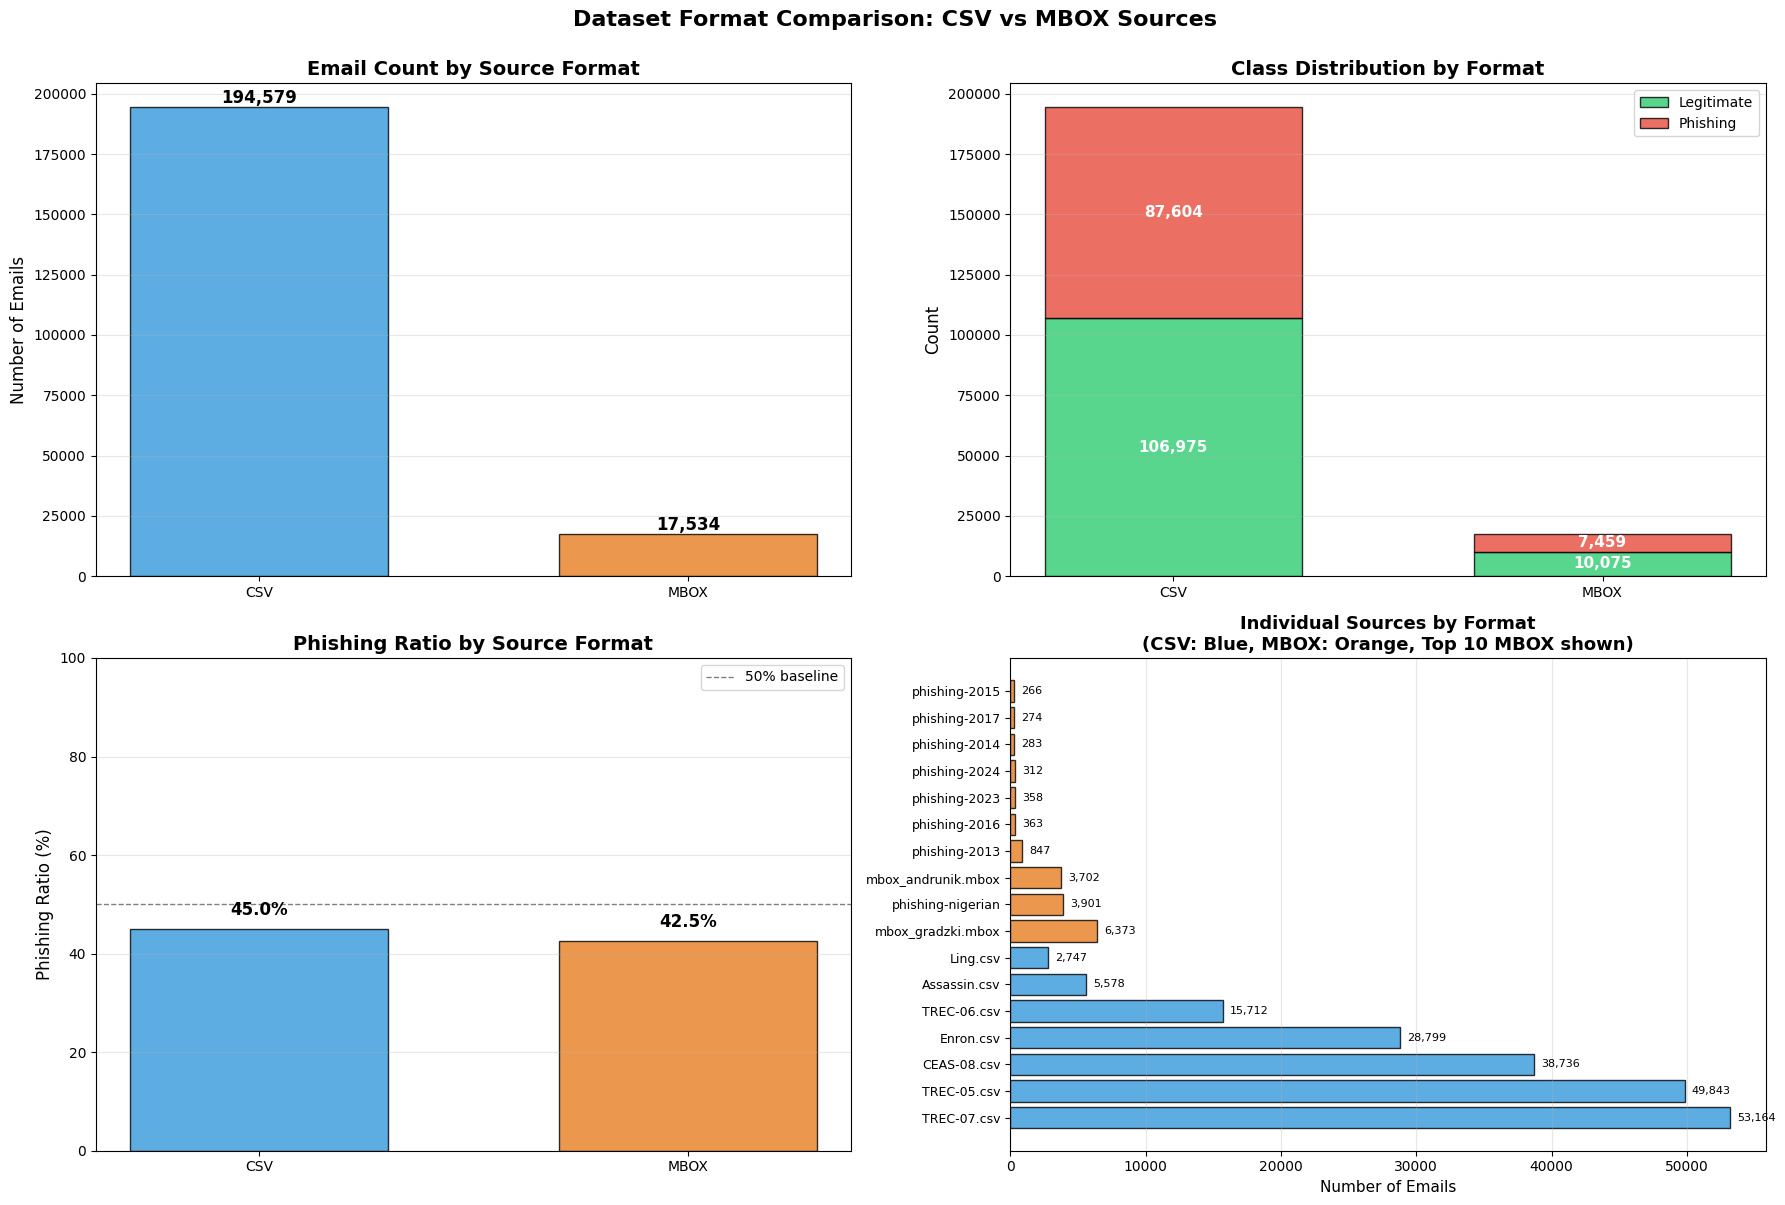


Format Breakdown:
  CSV sources:  194,579 emails (45.0% phishing)
  MBOX sources: 17,534 emails (42.5% phishing)


In [ ]:
# -------------------------------------------------------------------------
# Dataset Format Analysis (CSV vs MBOX)
# -------------------------------------------------------------------------
print("\n" + "=" * 80)
print("DATASET FORMAT ANALYSIS")
print("=" * 80)

# Classify sources by format
df_pd['format'] = df_pd['source'].apply(lambda x: 'CSV' if 'csv_misc' in x else 'MBOX')

# Calculate statistics by format
format_stats = df_pd.groupby('format').agg({
    'phishing': ['count', 'sum', 'mean']
}).reset_index()

format_stats.columns = ['format', 'total_count', 'phishing_count', 'phishing_ratio']
format_stats['legitimate_count'] = format_stats['total_count'] - format_stats['phishing_count']
format_stats['phishing_pct'] = format_stats['phishing_ratio'] * 100

print("\nFormat Statistics:")
print(format_stats.to_string(index=False))

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Count by format
ax1 = axes[0, 0]
formats = format_stats['format'].values
counts = format_stats['total_count'].values
colors_format = ['#3498db', '#e67e22']

bars = ax1.bar(formats, counts, color=colors_format, edgecolor='black', alpha=0.8, width=0.6)
ax1.set_ylabel('Number of Emails', fontsize=12)
ax1.set_title('Email Count by Source Format', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add count labels
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(count):,}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# 2. Stacked bar - class distribution by format
ax2 = axes[0, 1]
x_pos = np.arange(len(formats))
width = 0.6

legit_counts_fmt = format_stats['legitimate_count'].values
phish_counts_fmt = format_stats['phishing_count'].values

bars1 = ax2.bar(x_pos, legit_counts_fmt, width, label='Legitimate',
               color='#2ecc71', edgecolor='black', alpha=0.8)
bars2 = ax2.bar(x_pos, phish_counts_fmt, width, bottom=legit_counts_fmt,
               label='Phishing', color='#e74c3c', edgecolor='black', alpha=0.8)

ax2.set_xticks(x_pos)
ax2.set_xticklabels(formats)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Class Distribution by Format', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Add labels
for i, (bar1, bar2, legit, phish) in enumerate(zip(bars1, bars2, legit_counts_fmt, phish_counts_fmt)):
    # Legitimate label
    ax2.text(bar1.get_x() + bar1.get_width()/2., legit/2,
            f'{int(legit):,}',
            ha='center', va='center', fontsize=11, fontweight='bold', color='white')
    # Phishing label
    ax2.text(bar2.get_x() + bar2.get_width()/2., legit + phish/2,
            f'{int(phish):,}',
            ha='center', va='center', fontsize=11, fontweight='bold', color='white')

# 3. Phishing ratio comparison
ax3 = axes[1, 0]
phish_pcts = format_stats['phishing_pct'].values
bars = ax3.bar(formats, phish_pcts, color=colors_format, edgecolor='black', alpha=0.8, width=0.6)
ax3.set_ylabel('Phishing Ratio (%)', fontsize=12)
ax3.set_title('Phishing Ratio by Source Format', fontsize=14, fontweight='bold')
ax3.axhline(y=50, color='black', linestyle='--', linewidth=1, alpha=0.5, label='50% baseline')
ax3.set_ylim([0, 100])
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Add percentage labels
for bar, pct in zip(bars, phish_pcts):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{pct:.1f}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# 4. Source breakdown within each format
ax4 = axes[1, 1]

# Get top sources for each format
csv_sources = df_pd[df_pd['format'] == 'CSV']['source'].value_counts()
mbox_sources = df_pd[df_pd['format'] == 'MBOX']['source'].value_counts()

# Plot CSV sources
y_pos = 0
colors_bar = []
labels = []
values = []

for source, count in csv_sources.items():
    labels.append(source.split('/')[-1])
    values.append(count)
    colors_bar.append('#3498db')
    y_pos += 1

# Add separator
y_pos += 0.5

# Plot MBOX sources (top 10)
for source, count in mbox_sources.head(10).items():
    labels.append(source.split('/')[-1] if '/' in source else source)
    values.append(count)
    colors_bar.append('#e67e22')
    y_pos += 1

y_positions = np.arange(len(labels))
ax4.barh(y_positions, values, color=colors_bar, edgecolor='black', alpha=0.8)
ax4.set_yticks(y_positions)
ax4.set_yticklabels(labels, fontsize=9)
ax4.set_xlabel('Number of Emails', fontsize=11)
ax4.set_title('Individual Sources by Format\n(CSV: Blue, MBOX: Orange, Top 10 MBOX shown)',
              fontsize=13, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

# Add count labels
for y, val in zip(y_positions, values):
    ax4.text(val + max(values)*0.01, y, f'{int(val):,}',
            ha='left', va='center', fontsize=8)

plt.suptitle('Dataset Format Comparison: CSV vs MBOX Sources',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
wandb.log({"dataset_analysis/format_comparison": wandb.Image(fig)})
plt.show()
plt.close()

# Log format statistics
print(f"\nFormat Breakdown:")
print(f"  CSV sources:  {format_stats[format_stats['format']=='CSV']['total_count'].values[0]:,} emails "
      f"({format_stats[format_stats['format']=='CSV']['phishing_pct'].values[0]:.1f}% phishing)")
print(f"  MBOX sources: {format_stats[format_stats['format']=='MBOX']['total_count'].values[0]:,} emails "
      f"({format_stats[format_stats['format']=='MBOX']['phishing_pct'].values[0]:.1f}% phishing)")

wandb.log({"dataset_analysis/format_stats": wandb.Table(dataframe=format_stats)})


=== Text Length Statistics ===

Legitimate Emails:
  Total Length (body + subject): mean=2139.2, median=1063.0, std=11333.4
  Subject Length: mean=38.1, median=34.0
  Body Length: mean=2099.1, median=1023.0

Phishing Emails:
  Total Length (body + subject): mean=1201.2, median=626.0, std=3013.2
  Subject Length: mean=34.4, median=30.0
  Body Length: mean=1164.8, median=591.0


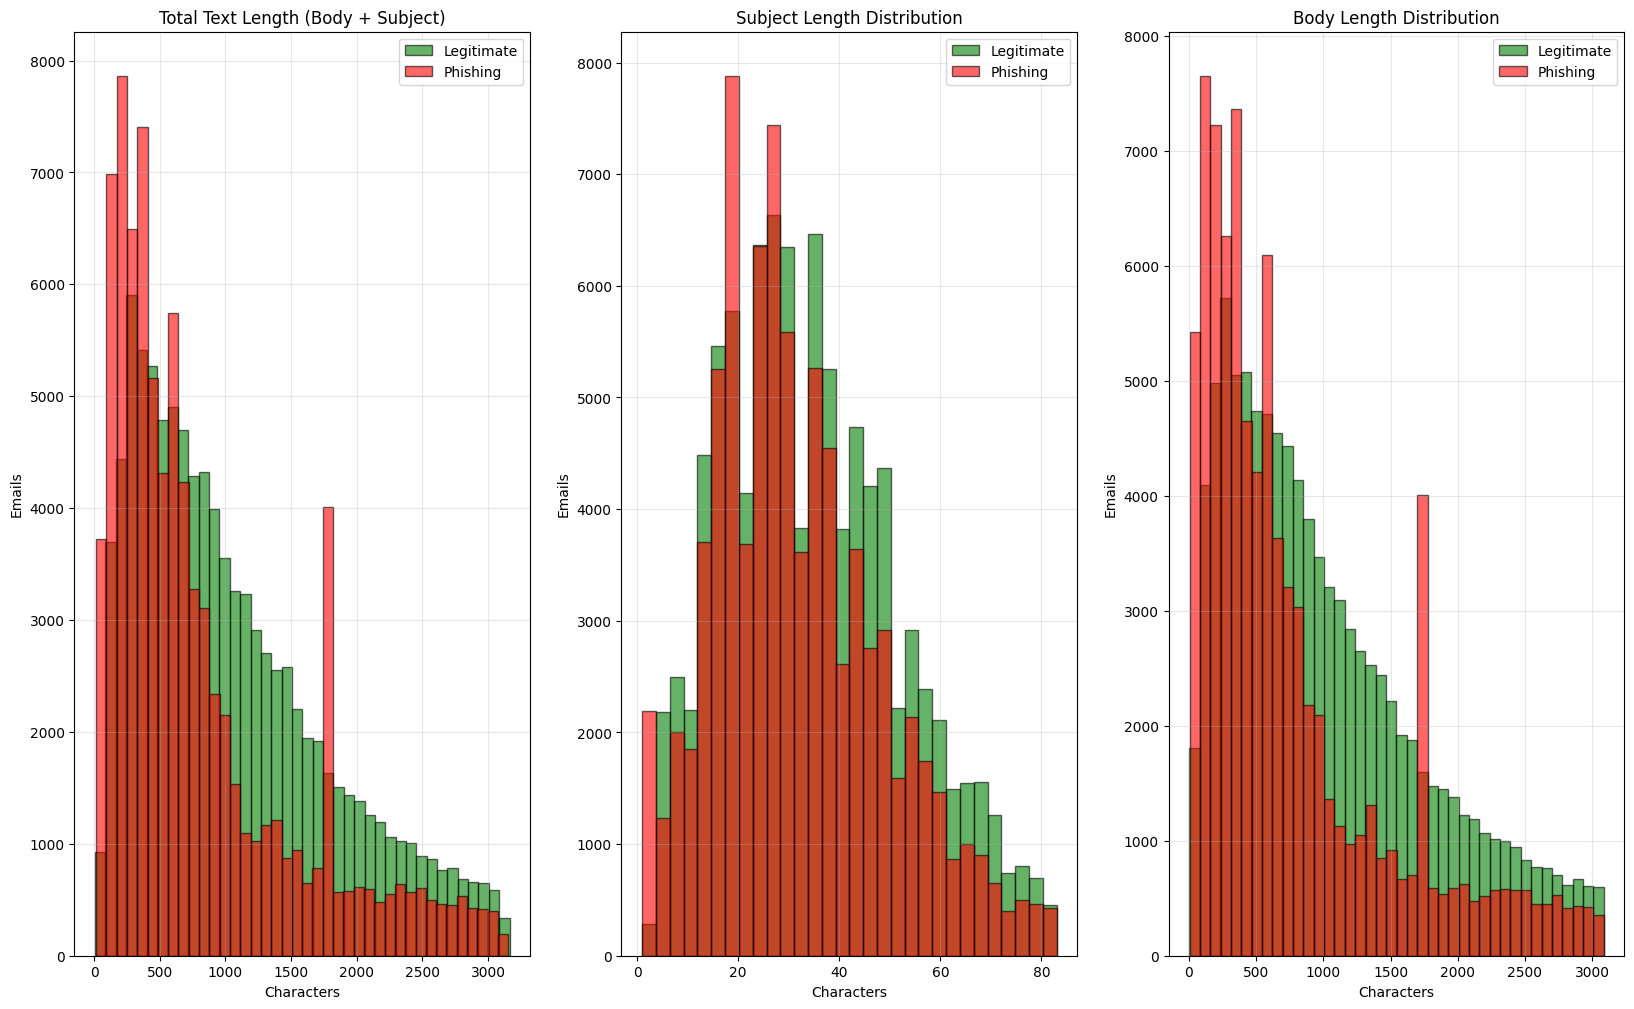

In [ ]:
df_pd["body_subject_length"] = df_pd["body_subject"].str.len()
df_pd["subject_length_actual"] = df_pd["subject"].str.len()
df_pd["body_length_actual"] = df_pd["body_text"].str.len()


print("\n=== Text Length Statistics ===")
for label, name in [(0, "Legitimate"), (1, "Phishing")]:
    subset = df_pd[df_pd["phishing"] == label]

    print(f"\n{name} Emails:")
    print(f"  Total Length (body + subject): "
          f"mean={subset['body_subject_length'].mean():.1f}, "
          f"median={subset['body_subject_length'].median():.1f}, "
          f"std={subset['body_subject_length'].std():.1f}")

    print(f"  Subject Length: mean={subset['subject_length_actual'].mean():.1f}, "
          f"median={subset['subject_length_actual'].median():.1f}")

    print(f"  Body Length: mean={subset['body_length_actual'].mean():.1f}, "
          f"median={subset['body_length_actual'].median():.1f}")

def remove_iqr_outliers_df(df, columns):
    """Remove outliers from dataframe using IQR method"""
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean


# Create filtered dataframe for visualization
length_cols = ["body_subject_length", "subject_length_actual", "body_length_actual"]
df_vis = remove_iqr_outliers_df(df_pd, length_cols)

LEGIT = df_vis[df_vis["phishing"] == 0]
PHISH = df_vis[df_vis["phishing"] == 1]

# -------------------------------------------------------------------------
# Plot Distributions
# -------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(20, 12))
axes = axes.flatten()

# ---------------------- 1. Total Length -------------------------
ax = axes[0]
ax.hist(LEGIT["body_subject_length"], bins=40, alpha=0.6,
        label="Legitimate", color="green", edgecolor="black")
ax.hist(PHISH["body_subject_length"], bins=40, alpha=0.6,
        label="Phishing", color="red", edgecolor="black")
ax.set_title("Total Text Length (Body + Subject)")
ax.set_xlabel("Characters")
ax.set_ylabel("Emails")
ax.grid(alpha=0.3)
ax.legend()

# ---------------------- 2. Subject Length -------------------------
ax = axes[1]
ax.hist(LEGIT["subject_length_actual"], bins=30, alpha=0.6,
        label="Legitimate", color="green", edgecolor="black")
ax.hist(PHISH["subject_length_actual"], bins=30, alpha=0.6,
        label="Phishing", color="red", edgecolor="black")
ax.set_title("Subject Length Distribution")
ax.set_xlabel("Characters")
ax.set_ylabel("Emails")
ax.grid(alpha=0.3)
ax.legend()

# ---------------------- 3. Body Length -------------------------
ax = axes[2]
ax.hist(LEGIT["body_length_actual"], bins=40, alpha=0.6,
        label="Legitimate", color="green", edgecolor="black")
ax.hist(PHISH["body_length_actual"], bins=40, alpha=0.6,
        label="Phishing", color="red", edgecolor="black")
ax.set_title("Body Length Distribution")
ax.set_xlabel("Characters")
ax.set_ylabel("Emails")
ax.grid(alpha=0.3)
ax.legend()

stats_table = []
for label, name in [(0, "Legitimate"), (1, "Phishing")]:
    subset = df_pd[df_pd["phishing"] == label]
    stats_table.append([
        name,
        subset["body_subject_length"].mean(),
        subset["body_subject_length"].median(),
        subset["body_subject_length"].std(),
        subset["subject_length_actual"].mean(),
        subset["body_length_actual"].mean(),
    ])

wandb.log({
    "dataset_analysis/text_length_stats": wandb.Table(
        columns=[
            "class",
            "avg_total_length",
            "median_total_length",
            "std_total_length",
            "avg_subject_length",
            "avg_body_length",
        ],
        data=stats_table
    )
})



Features dataframe shape: (212113, 12)
Columns: ['sender_domain_entropy', 'has_attachment', 'spf_flag_missing', 'dkim_flag_missing', 'num_links', 'subject_length', 'body_length', 'keyword_count', 'num_received_headers', 'num_exclamation_marks', 'num_malicious_links', 'phishing']

NUMERIC FEATURES DISTRIBUTION ANALYSIS (OUTLIERS REMOVED)
Outlier removal for num_links: removed 23684 rows
Outlier removal for keyword_count: removed 17124 rows
Outlier removal for num_received_headers: removed 3779 rows
Outlier removal for num_exclamation_marks: removed 20810 rows
Outlier removal for num_malicious_links: removed 1 rows
Outlier removal for sender_domain_entropy: removed 27248 rows

num_links:
  Legitimate: mean=30.076, median=2.000, std=41.548
  Phishing:   mean=24.336, median=23.000, std=29.284
  Difference: 5.739 (-19.1%)

keyword_count:
  Legitimate: mean=2.596, median=2.000, std=2.555
  Phishing:   mean=1.541, median=0.000, std=2.613
  Difference: 1.055 (-40.6%)

num_received_headers:
  

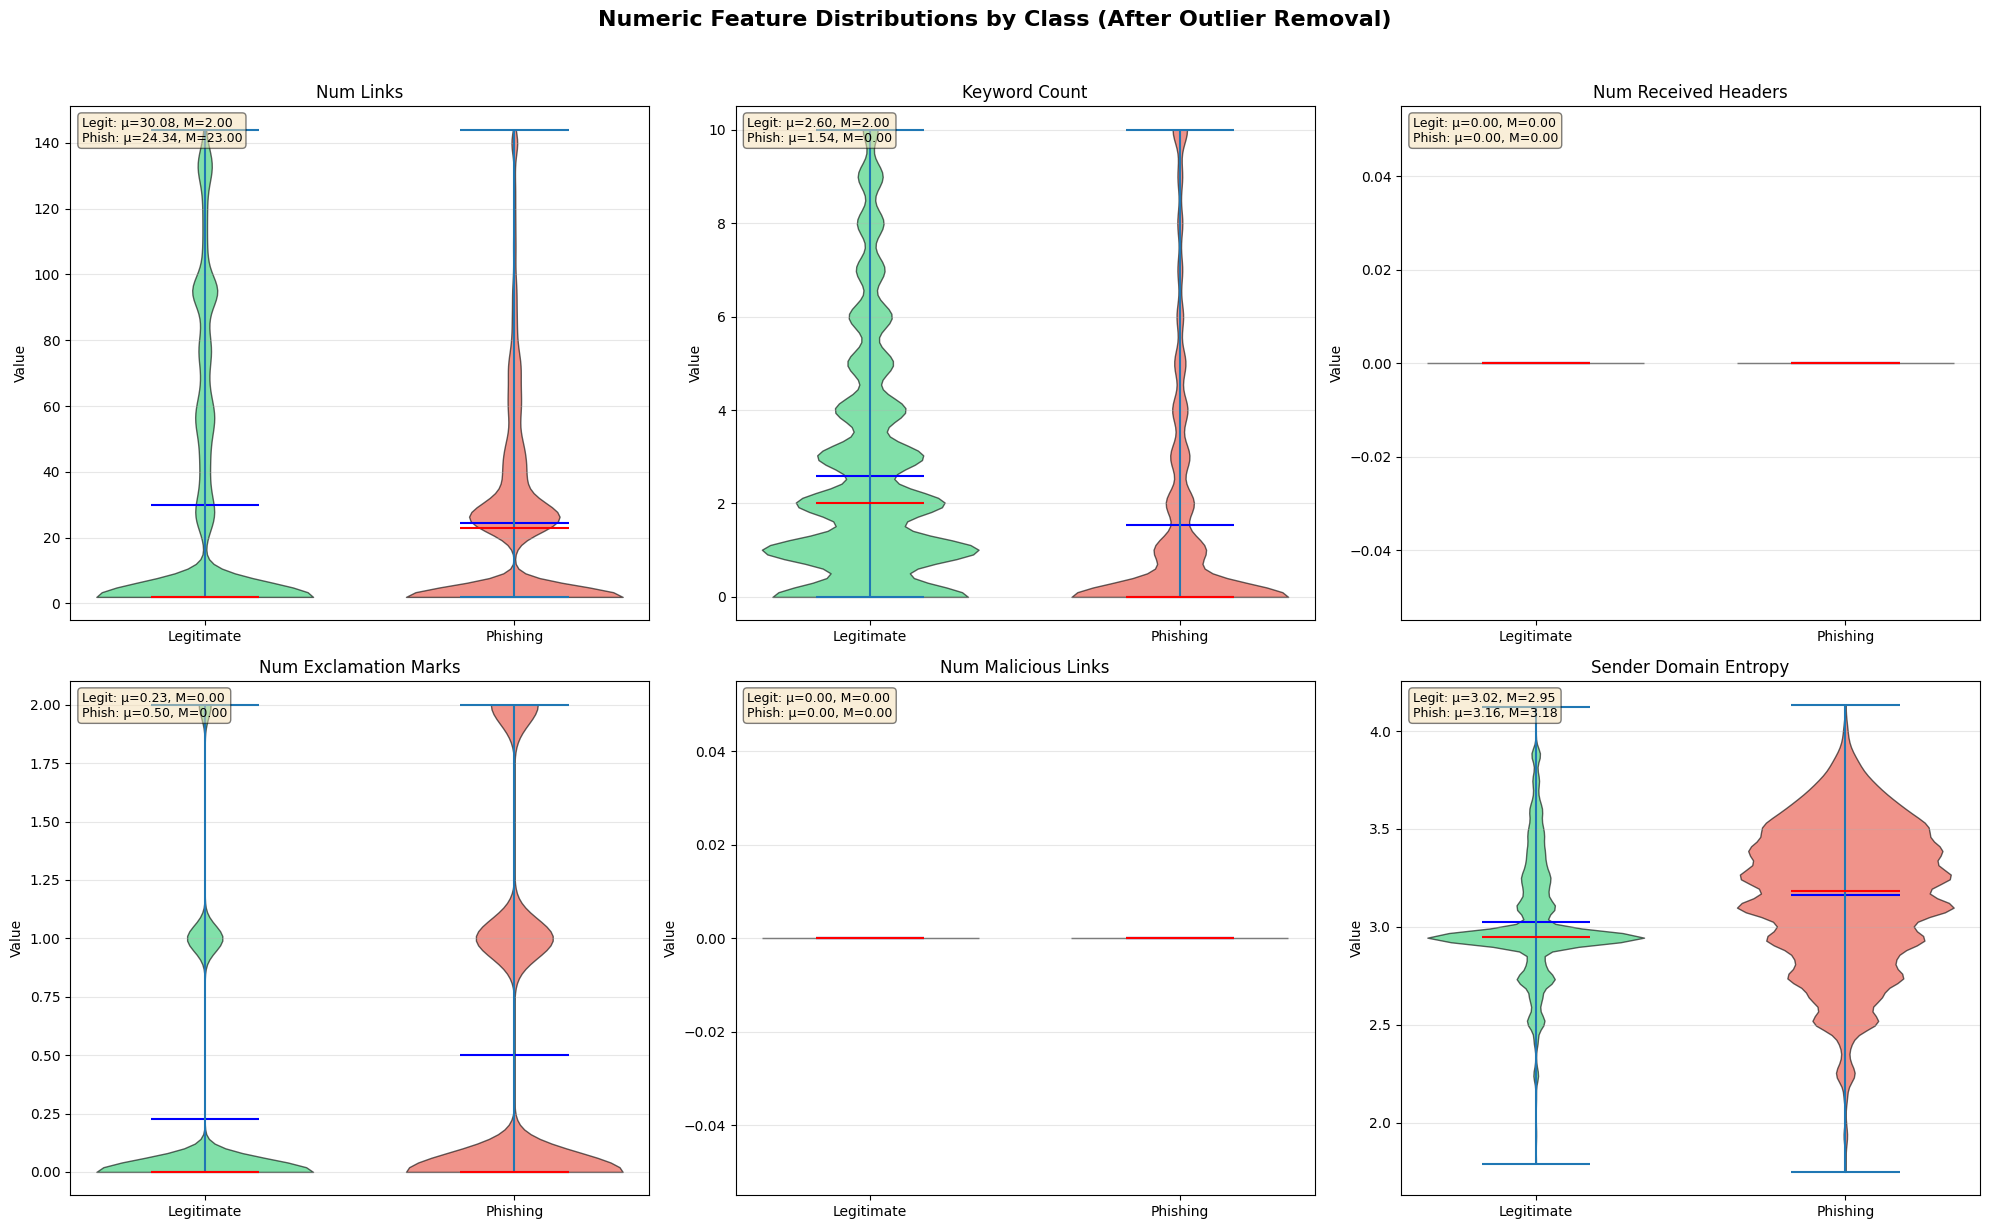

In [ ]:
numeric_features_analysis = [
    "sender_domain_entropy", "has_attachment",
    "spf_flag_missing", "dkim_flag_missing",
    "num_links", "subject_length", "body_length", "keyword_count", 
    "num_received_headers", "num_exclamation_marks", 
    "num_malicious_links"
]

features_analysis_df = df.select(numeric_features_analysis + ["phishing"]).to_pandas()

print(f"\nFeatures dataframe shape: {features_analysis_df.shape}")
print(f"Columns: {list(features_analysis_df.columns)}")

print("\n" + "=" * 80)
print("NUMERIC FEATURES DISTRIBUTION ANALYSIS (OUTLIERS REMOVED)")
print("=" * 80)

continuous_features = [
    "num_links",
   "keyword_count",
    "num_received_headers",
    "num_exclamation_marks",
    "num_malicious_links",
    "sender_domain_entropy",
]

def remove_outliers_iqr(df, columns):
    cleaned_df = df.copy()
    for col in columns:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        before = cleaned_df.shape[0]
        cleaned_df = cleaned_df[
            (cleaned_df[col] >= lower_bound) & (cleaned_df[col] <= upper_bound)
        ]
        after = cleaned_df.shape[0]

        print(f"Outlier removal for {col}: removed {before - after} rows")

    return cleaned_df


features_analysis_df = remove_outliers_iqr(features_analysis_df, continuous_features)


fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, feature in enumerate(continuous_features):
    ax = axes[idx]

    legit_vals = features_analysis_df[features_analysis_df["phishing"] == 0][feature]
    phish_vals = features_analysis_df[features_analysis_df["phishing"] == 1][feature]

    # Violin plot makes differences between classes easier to see
    parts = ax.violinplot(
        [legit_vals, phish_vals],
        positions=[0, 1],
        showmeans=True,
        showmedians=True,
        widths=0.7
    )

    # Color the violins
    for body, color in zip(parts["bodies"], ["#2ecc71", "#e74c3c"]):
        body.set_facecolor(color)
        body.set_alpha(0.6)
        body.set_edgecolor("black")

    parts["cmeans"].set_color("blue")
    parts["cmedians"].set_color("red")

    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Legitimate", "Phishing"])
    ax.set_ylabel("Value")
    ax.set_title(feature.replace("_", " ").title())
    ax.grid(axis="y", alpha=0.3)

    # Summary statistics printed on the plot
    legit_mean, legit_median = legit_vals.mean(), legit_vals.median()
    phish_mean, phish_median = phish_vals.mean(), phish_vals.median()

    stats_text = (
        f"Legit: μ={legit_mean:.2f}, M={legit_median:.2f}\n"
        f"Phish: μ={phish_mean:.2f}, M={phish_median:.2f}"
    )

    ax.text(
        0.02, 0.98, stats_text,
        transform=ax.transAxes,
        fontsize=9,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5)
    )

    # Print stats to console as well
    print(f"\n{feature}:")
    print(f"  Legitimate: mean={legit_mean:.3f}, median={legit_median:.3f}, std={legit_vals.std():.3f}")
    print(f"  Phishing:   mean={phish_mean:.3f}, median={phish_median:.3f}, std={phish_vals.std():.3f}")
    diff = phish_mean - legit_mean
    pct = (diff / legit_mean * 100) if legit_mean != 0 else 0
    print(f"  Difference: {abs(diff):.3f} ({pct:.1f}%)")

plt.suptitle("Numeric Feature Distributions by Class (After Outlier Removal)", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()

wandb.log({"dataset_analysis/numeric_features_distribution": wandb.Image(fig)})
plt.show()
plt.close()


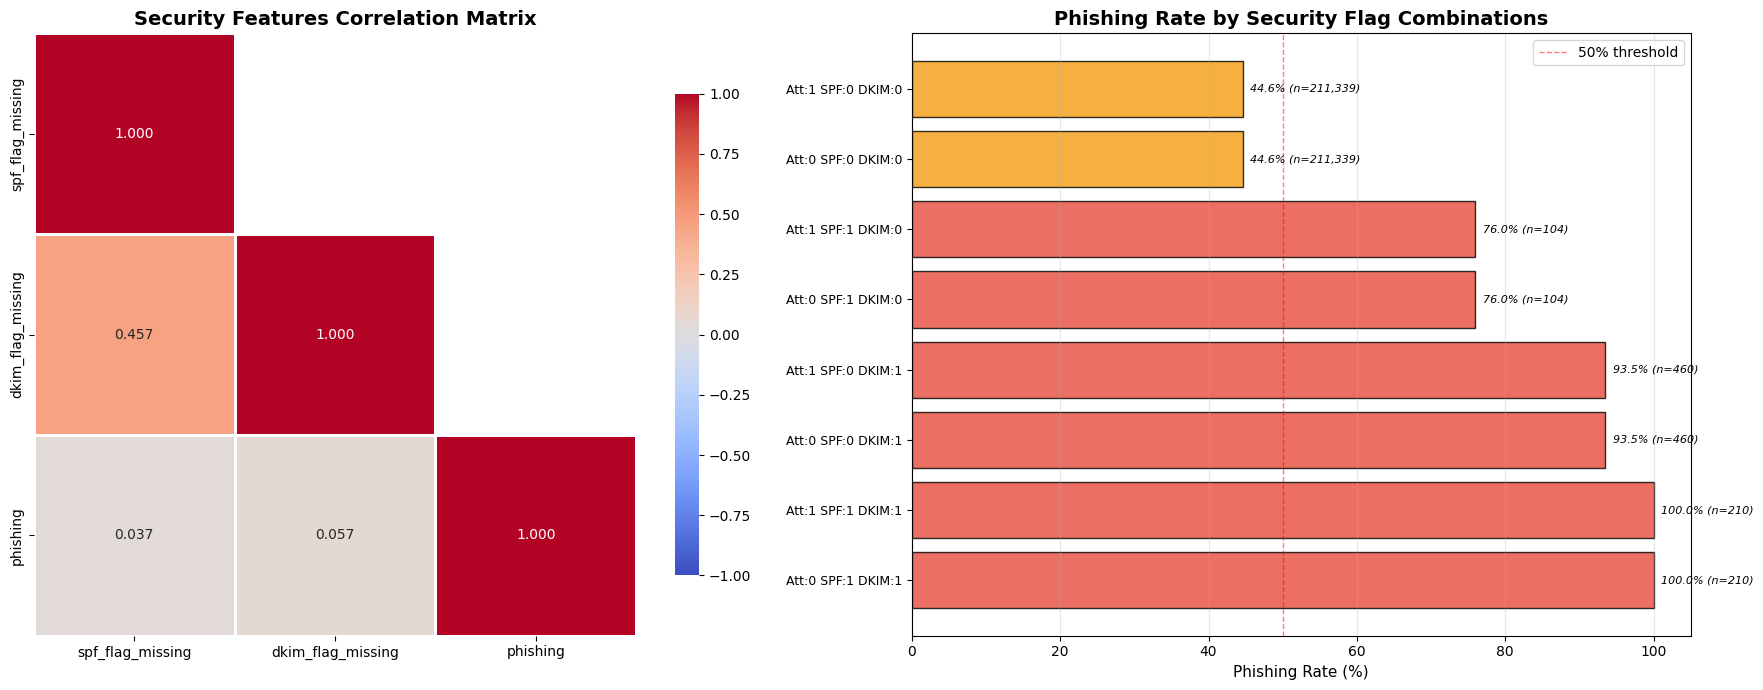


Key Insights:
  Highest risk combination: Att:0 SPF:1 DKIM:1 (100.0% phishing rate)
  Lowest risk combination: Att:1 SPF:0 DKIM:0 (44.6% phishing rate)


In [ ]:
# Create contingency tables and calculate correlations
security_features = [ 'spf_flag_missing', 'dkim_flag_missing', 'phishing']
security_df = df_pd[security_features].copy()

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 1. Correlation heatmap
ax1 = axes[0]
corr_matrix = security_df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, square=True, linewidths=2, cbar_kws={"shrink": 0.8},
            ax=ax1, vmin=-1, vmax=1)
ax1.set_title('Security Features Correlation Matrix', fontsize=14, fontweight='bold')

# 2. Combined security risk analysis
ax2 = axes[1]

# Count combinations
risk_combinations = []
risk_labels = []

for has_att in [0, 1]:
    for spf_miss in [0, 1]:
        for dkim_miss in [0, 1]:
            mask = (
                   (df_pd['spf_flag_missing'] == spf_miss) & 
                   (df_pd['dkim_flag_missing'] == dkim_miss))
            
            total = mask.sum()
            phishing = (mask & (df_pd['phishing'] == 1)).sum()
            phishing_rate = (phishing / total * 100) if total > 0 else 0
            
            if total >= 10:  # Only include combinations with sufficient samples
                label = f"Att:{has_att} SPF:{spf_miss} DKIM:{dkim_miss}"
                risk_combinations.append({
                    'label': label,
                    'total': total,
                    'phishing_rate': phishing_rate,
                    'spf_missing': spf_miss,
                    'dkim_missing': dkim_miss
                })

# Sort by phishing rate
risk_combinations.sort(key=lambda x: x['phishing_rate'], reverse=True)

# Plot
y_pos = np.arange(len(risk_combinations))
rates = [r['phishing_rate'] for r in risk_combinations]
labels = [r['label'] for r in risk_combinations]
totals = [r['total'] for r in risk_combinations]

# Color bars by risk level
colors = ['#e74c3c' if rate > 50 else '#f39c12' if rate > 25 else '#2ecc71' 
          for rate in rates]

bars = ax2.barh(y_pos, rates, color=colors, edgecolor='black', alpha=0.8)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(labels, fontsize=9)
ax2.set_xlabel('Phishing Rate (%)', fontsize=11)
ax2.set_title('Phishing Rate by Security Flag Combinations', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
ax2.axvline(x=50, color='red', linestyle='--', linewidth=1, alpha=0.5, label='50% threshold')
ax2.legend()

# Add count labels
for i, (bar, rate, total) in enumerate(zip(bars, rates, totals)):
    ax2.text(rate + 1, bar.get_y() + bar.get_height()/2,
            f'{rate:.1f}% (n={total:,})',
            ha='left', va='center', fontsize=8, style='italic')

plt.tight_layout()
wandb.log({"dataset_analysis/security_flags_correlation": wandb.Image(fig)})
plt.show()
plt.close()

# Print key insights
print("\nKey Insights:")
print(f"  Highest risk combination: {risk_combinations[0]['label']} "
      f"({risk_combinations[0]['phishing_rate']:.1f}% phishing rate)")
print(f"  Lowest risk combination: {risk_combinations[-1]['label']} "
      f"({risk_combinations[-1]['phishing_rate']:.1f}% phishing rate)")


COMPREHENSIVE DATASET SUMMARY

     Class  Count  Avg Subject Length  Avg Body Length  Avg Links  Avg Malicious Links  Avg Keywords  Avg Exclamation Marks  % With Attachments  % SPF Missing  % DKIM Missing  Avg Domain Entropy
Legitimate  68849           37.178289      1217.994147  30.075745                  0.0      2.596319               0.225464            0.015977            0.0             0.0            3.024529
  Phishing  50618           34.003497       722.878759  24.336363                  0.0      1.541171               0.502134            0.039512            0.0             0.0            3.163203


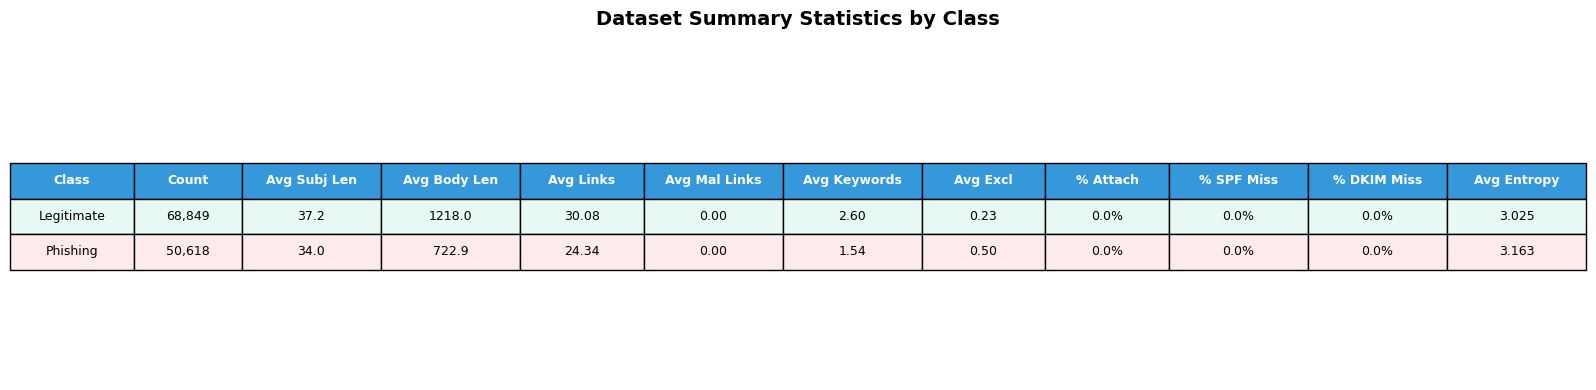

In [ ]:
# 9. Dataset Summary Statistics Table
print("\n" + "="*80)
print("COMPREHENSIVE DATASET SUMMARY")
print("="*80)

summary_stats = []
for class_label, class_name in [(0, 'Legitimate'), (1, 'Phishing')]:
    subset = features_analysis_df[features_analysis_df['phishing'] == class_label]
    
    stats = {
        'Class': class_name,
        'Count': len(subset),
        'Avg Subject Length': subset['subject_length'].mean(),
        'Avg Body Length': subset['body_length'].mean(),
        'Avg Links': subset['num_links'].mean(),
        'Avg Malicious Links': subset['num_malicious_links'].mean(),
        'Avg Keywords': subset['keyword_count'].mean(),
        'Avg Exclamation Marks': subset['num_exclamation_marks'].mean(),
        '% With Attachments': (subset['has_attachment'] == 1).sum() / len(subset) * 100,
        '% SPF Missing': (subset['spf_flag_missing'] == 1).sum() / len(subset) * 100,
        '% DKIM Missing': (subset['dkim_flag_missing'] == 1).sum() / len(subset) * 100,
        'Avg Domain Entropy': subset['sender_domain_entropy'].mean(),
    }
    summary_stats.append(stats)

summary_df = pd.DataFrame(summary_stats)
print("\n" + summary_df.to_string(index=False))

# Create a visual table
fig, ax = plt.subplots(figsize=(16, 4))
ax.axis('tight')
ax.axis('off')

table_data = []
for _, row in summary_df.iterrows():
    table_row = [row['Class'], f"{row['Count']:,}",
                 f"{row['Avg Subject Length']:.1f}",
                 f"{row['Avg Body Length']:.1f}",
                 f"{row['Avg Links']:.2f}",
                 f"{row['Avg Malicious Links']:.2f}",
                 f"{row['Avg Keywords']:.2f}",
                 f"{row['Avg Exclamation Marks']:.2f}",
                 f"{row['% With Attachments']:.1f}%",
                 f"{row['% SPF Missing']:.1f}%",
                 f"{row['% DKIM Missing']:.1f}%",
                 f"{row['Avg Domain Entropy']:.3f}"]
    table_data.append(table_row)

table = ax.table(cellText=table_data,
                colLabels=['Class', 'Count', 'Avg Subj Len', 'Avg Body Len', 
                          'Avg Links', 'Avg Mal Links', 'Avg Keywords', 'Avg Excl',
                          '% Attach', '% SPF Miss', '% DKIM Miss', 'Avg Entropy'],
                cellLoc='center',
                loc='center',
                colWidths=[0.08, 0.07, 0.09, 0.09, 0.08, 0.09, 0.09, 0.08, 0.08, 0.09, 0.09, 0.09])

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Color header
for i in range(len(summary_df.columns)):
    table[(0, i)].set_facecolor('#3498db')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Color rows
for i in range(len(table_data)):
    color = '#e8f8f5' if i == 0 else '#fdeaea'
    for j in range(len(summary_df.columns)):
        table[(i+1, j)].set_facecolor(color)

plt.title('Dataset Summary Statistics by Class', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
wandb.log({"dataset_analysis/summary_table": wandb.Image(fig)})
plt.show()
plt.close()

# Log summary table to WandB
wandb.log({"dataset_analysis/summary_stats": wandb.Table(dataframe=summary_df)})

## 4. Create Standardized Train/Test/External Splits

In [ ]:

from app.data_processing.preprocessing_pipeline import PreprocessingPipeline

df = PreprocessingPipeline().process_pipeline(df)
external_df = df.filter(
    (pl.col("source") == "data/csv_misc/TREC-07.csv") | (pl.col("source") == "phishing-2020")
)

train_pool_df = df.filter(
    (pl.col("source") != "data/csv_misc/TREC-07.csv") & (pl.col("source") != "phishing-2020")
)

print(f"Training pool: {len(train_pool_df):,}")
print(f"External validation: {len(external_df):,}")

train_pool_pd = train_pool_df.to_pandas()

train_df_pd, test_df_pd = train_test_split(
    train_pool_pd, 
    test_size=0.25, 
    random_state=config["random_seed"], 
    stratify=train_pool_pd['phishing']
)

train_df = pl.from_pandas(train_df_pd)
test_df = pl.from_pandas(test_df_pd)

print(f"\nFinal splits:")
print(f"  Train: {len(train_df):,} ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Test: {len(test_df):,} ({len(test_df)/len(df)*100:.1f}%)")
print(f"  External: {len(external_df):,} ({len(external_df)/len(df)*100:.1f}%)")

for name, split_df in [("Train", train_df), ("Test", test_df), ("External", external_df)]:
    phish = split_df.filter(pl.col("phishing") == 1).shape[0]
    total = len(split_df)
    print(f"\n{name} set:")
    print(f"  Phishing: {phish:,} ({phish/total*100:.2f}%)")
    print(f"  Legitimate: {total-phish:,} ({(total-phish)/total*100:.2f}%)")
    
    wandb.log({
        f"{name.lower()}_size": total,
        f"{name.lower()}_phishing_ratio": phish / total
    })
numeric_features = config["numeric_features"]

print(f"Extracting {len(numeric_features)} engineered features...")

features_train = train_df.select(numeric_features).fill_null(0).to_numpy()
features_test = test_df.select(numeric_features).fill_null(0).to_numpy()
features_external = external_df.select(numeric_features).fill_null(0).to_numpy()


Training pool: 158,828
External validation: 53,285

Final splits:
  Train: 119,121 (56.2%)
  Test: 39,707 (18.7%)
  External: 53,285 (25.1%)

Train set:
  Phishing: 49,560 (41.60%)
  Legitimate: 69,561 (58.40%)

Test set:
  Phishing: 16,520 (41.60%)
  Legitimate: 23,187 (58.40%)

External set:
  Phishing: 28,983 (54.39%)
  Legitimate: 24,302 (45.61%)
Extracting 11 engineered features...


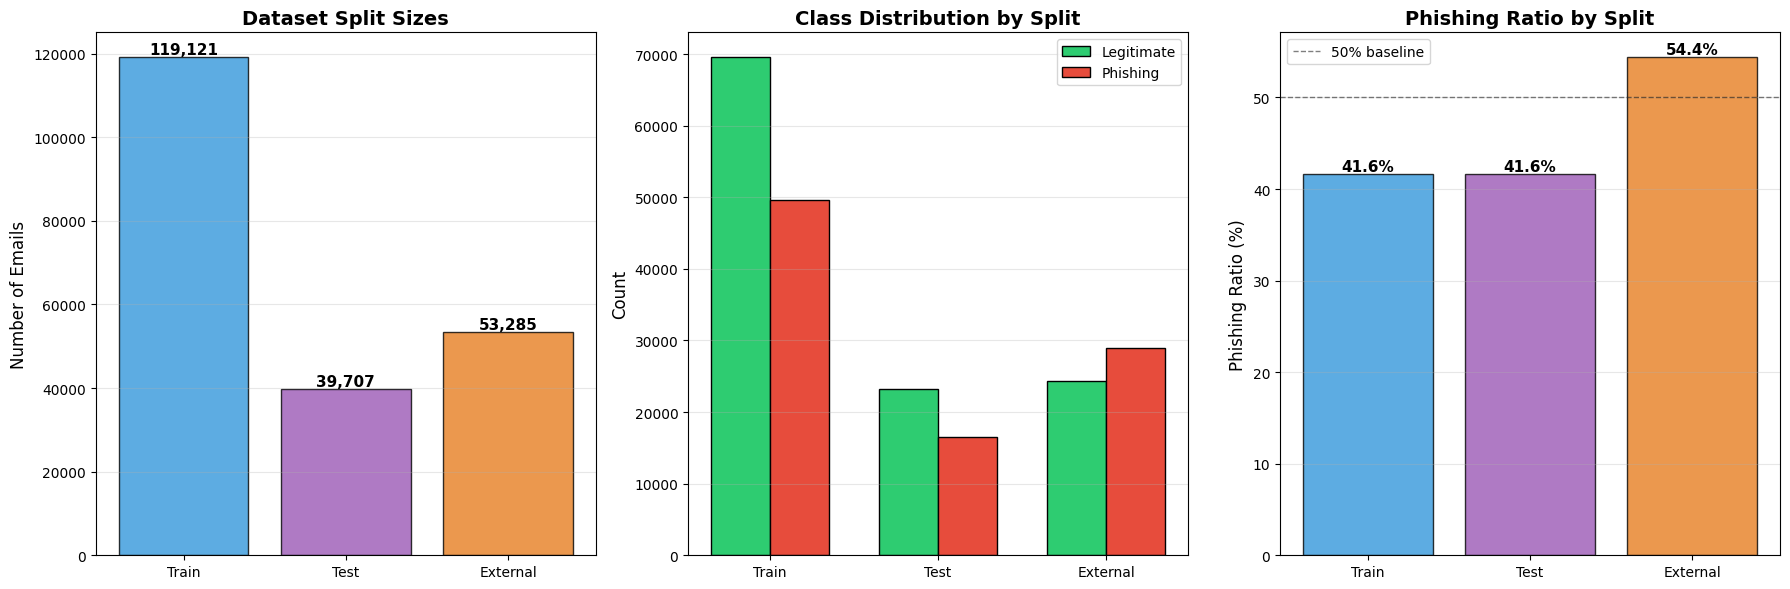

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

splits_data = {
    'Train': train_df,
    'Test': test_df,
    'External': external_df
}

ax1 = axes[0]
sizes = [len(train_df), len(test_df), len(external_df)]
colors_splits = ['#3498db', '#9b59b6', '#e67e22']
bars = ax1.bar(['Train', 'Test', 'External'], sizes, color=colors_splits, edgecolor='black', alpha=0.8)
ax1.set_ylabel('Number of Emails', fontsize=12)
ax1.set_title('Dataset Split Sizes', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2 = axes[1]
x_pos = np.arange(3)
width = 0.35
phishing_counts = [
    train_df.filter(pl.col("phishing") == 1).shape[0],
    test_df.filter(pl.col("phishing") == 1).shape[0],
    external_df.filter(pl.col("phishing") == 1).shape[0]
]
legit_counts = [
    train_df.filter(pl.col("phishing") == 0).shape[0],
    test_df.filter(pl.col("phishing") == 0).shape[0],
    external_df.filter(pl.col("phishing") == 0).shape[0]
]
ax2.bar(x_pos - width/2, legit_counts, width, label='Legitimate', color='#2ecc71', edgecolor='black')
ax2.bar(x_pos + width/2, phishing_counts, width, label='Phishing', color='#e74c3c', edgecolor='black')
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Class Distribution by Split', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(['Train', 'Test', 'External'])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

ax3 = axes[2]
phishing_ratios = [
    phishing_counts[0] / sizes[0] * 100,
    phishing_counts[1] / sizes[1] * 100,
    phishing_counts[2] / sizes[2] * 100
]
bars = ax3.bar(['Train', 'Test', 'External'], phishing_ratios, color=colors_splits, edgecolor='black', alpha=0.8)
ax3.set_ylabel('Phishing Ratio (%)', fontsize=12)
ax3.set_title('Phishing Ratio by Split', fontsize=14, fontweight='bold')
ax3.axhline(y=50, color='black', linestyle='--', linewidth=1, alpha=0.5, label='50% baseline')
ax3.grid(axis='y', alpha=0.3)
ax3.legend()

for bar, ratio in zip(bars, phishing_ratios):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{ratio:.1f}%',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
wandb.log({"dataset_analysis/split_distributions": wandb.Image(fig)})
plt.show()
plt.close()

split_info_data = []
for split_name, split_df_pl in [('Train', train_df), ('Test', test_df), ('External', external_df)]:
    phish = split_df_pl.filter(pl.col("phishing") == 1).shape[0]
    total = len(split_df_pl)
    split_info_data.append([split_name, total, phish, total - phish, phish / total * 100])

wandb.log({"dataset_analysis/split_info": wandb.Table(
    columns=["split", "total", "phishing", "legitimate", "phishing_ratio_%"],
    data=split_info_data
)})


## 6. Generate Text Embeddings

In [ ]:
# Load sentence transformer model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Generating embeddings on {device}...")

embedding_model = SentenceTransformer(config["embedding_model"], device=device)

# Generate embeddings for each split
print("Encoding train set...")
X_emb_train = embedding_model.encode(
    train_df['body_subject'].to_list(), 
    show_progress_bar=True, 
    convert_to_numpy=True,
    batch_size=32
)

print("Encoding test set...")
X_emb_test = embedding_model.encode(
    test_df['body_subject'].to_list(), 
    show_progress_bar=True, 
    convert_to_numpy=True,
    batch_size=32
)

print("Encoding external set...")
X_emb_external = embedding_model.encode(
    external_df['body_subject'].to_list(), 
    show_progress_bar=True, 
    convert_to_numpy=True,
    batch_size=32
)

# Extract labels
y_train = train_df['phishing'].to_numpy()
y_test = test_df['phishing'].to_numpy()
y_external = external_df['phishing'].to_numpy()

print(f"\nEmbedding shapes:")
print(f"  Train: {X_emb_train.shape}")
print(f"  Test: {X_emb_test.shape}")
print(f"  External: {X_emb_external.shape}")

wandb.log({
    "embedding_dim": X_emb_train.shape[1],
    "embedding_model": config["embedding_model"]
})

Generating embeddings on cuda...
Encoding train set...


Batches: 100%|██████████| 3723/3723 [03:08<00:00, 19.73it/s] 


Encoding test set...


Batches: 100%|██████████| 1241/1241 [01:00<00:00, 20.65it/s] 


Encoding external set...


Batches: 100%|██████████| 1666/1666 [01:21<00:00, 20.51it/s]



Embedding shapes:
  Train: (119121, 384)
  Test: (39707, 384)
  External: (53285, 384)


## 7. Train TF-IDF Baseline Model

Combined feature shape: (119121, 5011)
  TF-IDF features: 5000
  Engineered features: 11

 Using class weights: {0: 1.0, 1: 3.0} (phishing class gets 3.0x weight)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished



 Using phishing threshold: 0.35 (default is 0.5)

Test Set Metrics (threshold=0.35):
  accuracy: 0.9555
  precision: 0.9093
  recall: 0.9920
  f1: 0.9488
  roc_auc: 0.9963

External Set Metrics (threshold=0.35):
  accuracy: 0.9126
  precision: 0.8956
  recall: 0.9500
  f1: 0.9220
  roc_auc: 0.9616
 1. right to                       -12.911601
 2. aggressive                     -10.598795
 3. sm                             -10.525958
 4. thus                           +7.748507
 5. num_links                      -7.604038
 6. to that                        +7.516887
 7. project                        -7.077321
 8. flights                        -6.739763
 9. 2nd                            -6.713078
10. in their                       -6.231632
11. driven                         +5.877720
12. programming                    -5.861189
13. derivatives                    -5.781867
14. ankle                          -5.777213
15. brian                          -5.768583
16. material          

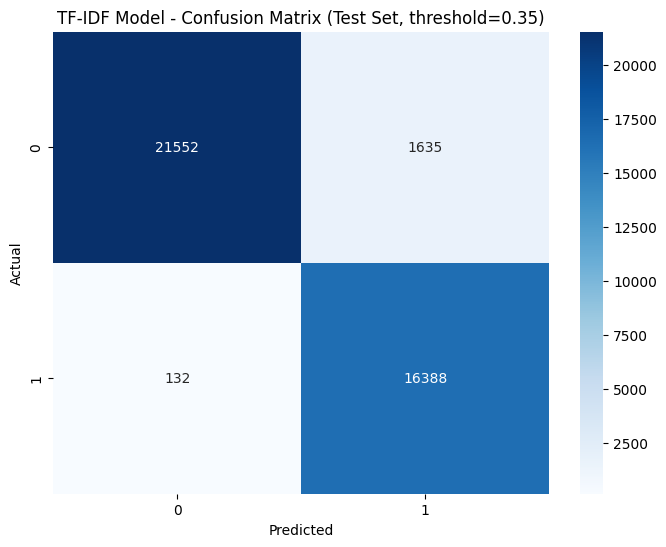

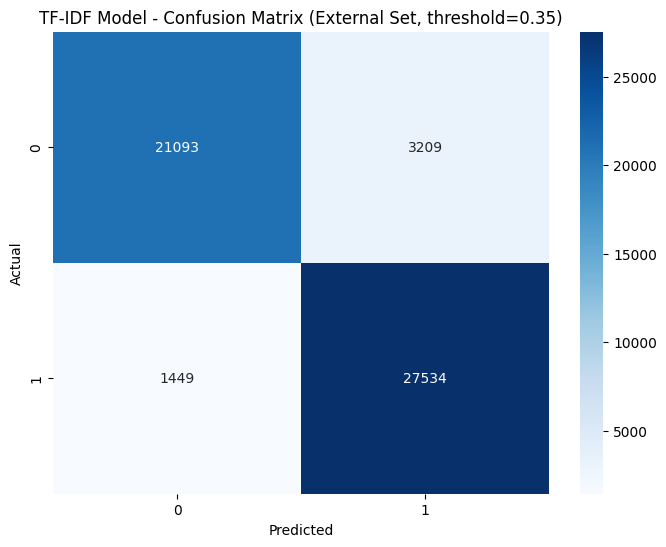

In [ ]:
from scipy.sparse import hstack
tfidf = TfidfVectorizer(
    max_features=config["tfidf_max_features"],
    ngram_range=config["tfidf_ngram_range"],
    min_df=config["tfidf_min_df"],
    max_df=config["tfidf_max_df"]
)


X_tfidf_train = tfidf.fit_transform(train_df['body_subject'].to_list())
X_tfidf_test = tfidf.transform(test_df['body_subject'].to_list())
X_tfidf_external = tfidf.transform(external_df['body_subject'].to_list())

X_combined_train = hstack([X_tfidf_train, features_train])
X_combined_test = hstack([X_tfidf_test, features_test])
X_combined_external = hstack([X_tfidf_external, features_external])

print(f"Combined feature shape: {X_combined_train.shape}")
print(f"  TF-IDF features: {X_tfidf_train.shape[1]}")
print(f"  Engineered features: {features_train.shape[1]}")

class_weights = {0: 1.0, 1: config['lr_class_weight_ratio']}

lr_clf = LogisticRegression(
    max_iter=config["lr_max_iter"],
    C=config["lr_C"],
    class_weight=class_weights,
    random_state=config["random_seed"],
    verbose=1
)
lr_clf.fit(X_combined_train, y_train)

phishing_threshold = config['tfidf_threshold']
print(f"\nUsing threshold: {phishing_threshold}")

# Evaluate on test set
y_proba_test_tfidf = lr_clf.predict_proba(X_combined_test)[:, 1]
y_pred_test_tfidf = (y_proba_test_tfidf >= phishing_threshold).astype(int)

tfidf_test_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_test_tfidf),
    'precision': precision_score(y_test, y_pred_test_tfidf, zero_division=0),
    'recall': recall_score(y_test, y_pred_test_tfidf, zero_division=0),
    'f1': f1_score(y_test, y_pred_test_tfidf, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_proba_test_tfidf)
}

# Evaluate on external set
y_proba_ext_tfidf = lr_clf.predict_proba(X_combined_external)[:, 1]
y_pred_ext_tfidf = (y_proba_ext_tfidf >= phishing_threshold).astype(int)

tfidf_external_metrics = {
    'accuracy': accuracy_score(y_external, y_pred_ext_tfidf),
    'precision': precision_score(y_external, y_pred_ext_tfidf, zero_division=0),
    'recall': recall_score(y_external, y_pred_ext_tfidf, zero_division=0),
    'f1': f1_score(y_external, y_pred_ext_tfidf, zero_division=0),
    'roc_auc': roc_auc_score(y_external, y_proba_ext_tfidf)
}

print(f"\nTF-IDF + Logistic Regression (threshold={phishing_threshold})")
print(f"\nTest Set Performance:")
print(f"  Accuracy:  {tfidf_test_metrics['accuracy']:.4f}")
print(f"  Precision: {tfidf_test_metrics['precision']:.4f}")
print(f"  Recall:    {tfidf_test_metrics['recall']:.4f}")
print(f"  F1 Score:  {tfidf_test_metrics['f1']:.4f}")
print(f"  ROC-AUC:   {tfidf_test_metrics['roc_auc']:.4f}")

print(f"\nExternal Validation:")
print(f"  Accuracy:  {tfidf_external_metrics['accuracy']:.4f}")
print(f"  Precision: {tfidf_external_metrics['precision']:.4f}")
print(f"  Recall:    {tfidf_external_metrics['recall']:.4f}")
print(f"  F1 Score:  {tfidf_external_metrics['f1']:.4f}")
print(f"  ROC-AUC:   {tfidf_external_metrics['roc_auc']:.4f}")

feature_names = list(tfidf.vocabulary_.keys()) + numeric_features
coefficients = lr_clf.coef_[0]
feature_importance = sorted(zip(feature_names, coefficients), key=lambda x: abs(x[1]), reverse=True)

print(f"\nTop 20 most important features:")
for i, (name, coef) in enumerate(feature_importance[:20], 1):
    print(f"{i:2d}. {name:<30s} {coef:+.6f}")

# Log to WandB
wandb.log({
    "tfidf/phishing_threshold": phishing_threshold,
    "tfidf/class_weight_ratio": config['lr_class_weight_ratio'],
    "tfidf/test_accuracy": tfidf_test_metrics['accuracy'],
    "tfidf/test_precision": tfidf_test_metrics['precision'],
    "tfidf/test_recall": tfidf_test_metrics['recall'],
    "tfidf/test_f1": tfidf_test_metrics['f1'],
    "tfidf/test_roc_auc": tfidf_test_metrics['roc_auc'],
    "tfidf/external_accuracy": tfidf_external_metrics['accuracy'],
    "tfidf/external_precision": tfidf_external_metrics['precision'],
    "tfidf/external_recall": tfidf_external_metrics['recall'],
    "tfidf/external_f1": tfidf_external_metrics['f1'],
    "tfidf/external_roc_auc": tfidf_external_metrics['roc_auc'],
})

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test_tfidf)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'TF-IDF Model - Confusion Matrix (Test Set, threshold={phishing_threshold})')
plt.show()
wandb.log({"tfidf/confusion_matrix": wandb.Image(fig)})
plt.close()

cm = confusion_matrix(y_external, y_pred_ext_tfidf)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'TF-IDF Model - Confusion Matrix (External Set, threshold={phishing_threshold})')
plt.show()
wandb.log({"tfidf/confusion_matrix": wandb.Image(fig)})
plt.close()

## 8. Train Hybrid XGBoost Model

Combined feature shape: (119121, 395)
  Full embeddings: 384
  Engineered features: 11

 Using scale_pos_weight: 3.0 (penalizes missing phishing emails)

Training XGBoost...
[0]	validation_0-logloss:0.73641	validation_0-auc:0.93586	validation_1-logloss:0.73913	validation_1-auc:0.92207
[10]	validation_0-logloss:0.35763	validation_0-auc:0.99001	validation_1-logloss:0.37975	validation_1-auc:0.98050
[20]	validation_0-logloss:0.21756	validation_0-auc:0.99574	validation_1-logloss:0.24927	validation_1-auc:0.98783
[30]	validation_0-logloss:0.14794	validation_0-auc:0.99790	validation_1-logloss:0.18502	validation_1-auc:0.99116
[40]	validation_0-logloss:0.10751	validation_0-auc:0.99891	validation_1-logloss:0.14736	validation_1-auc:0.99320
[50]	validation_0-logloss:0.08189	validation_0-auc:0.99943	validation_1-logloss:0.12425	validation_1-auc:0.99439
[60]	validation_0-logloss:0.06429	validation_0-auc:0.99970	validation_1-logloss:0.10858	validation_1-auc:0.99522
[70]	validation_0-logloss:0.05221	va

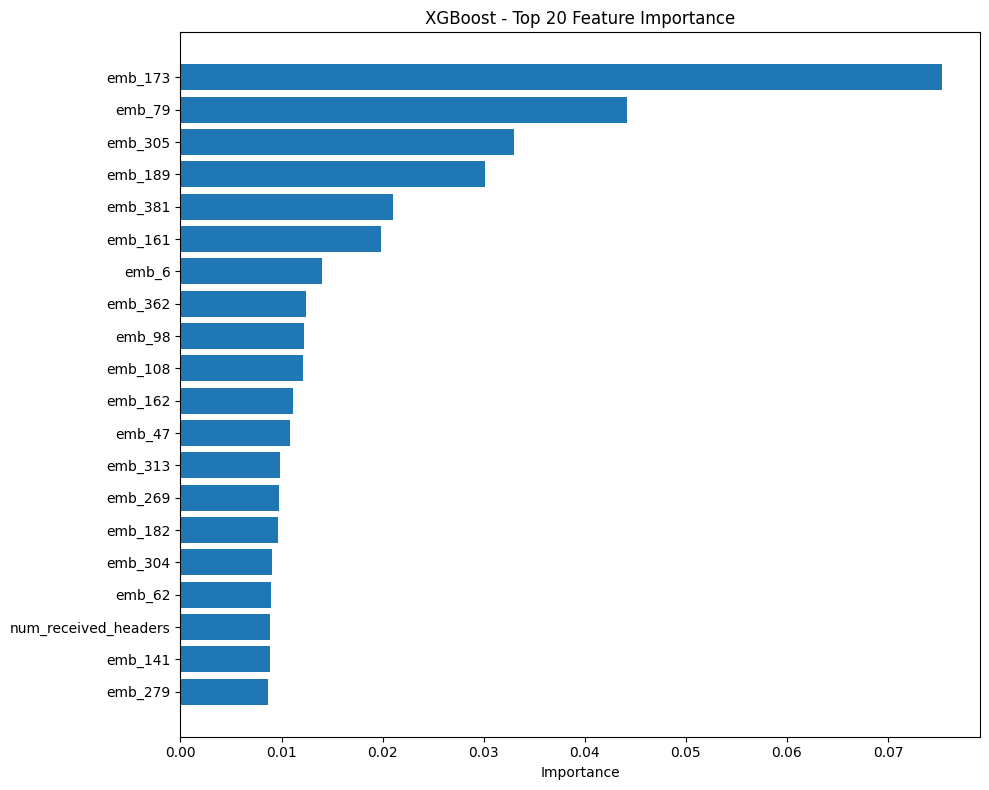

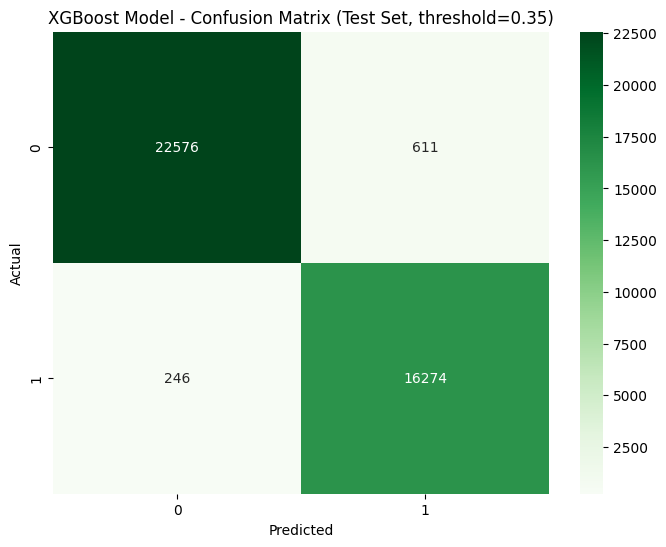

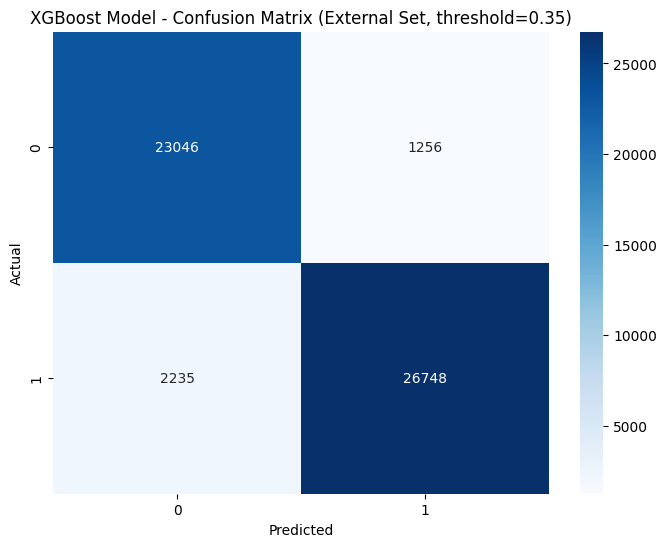

In [ ]:
from hybrid_mlp_model import HybridMLPClassifier

X_emb_train_fit, X_emb_val, X_feat_train_fit, X_feat_val, y_train_fit, y_val = train_test_split(
    X_emb_train, features_train, y_train, 
    test_size=0.2, 
    random_state=config["random_seed"], 
    stratify=y_train
)

print(f"Train: {X_emb_train_fit.shape[0]} | Val: {X_emb_val.shape[0]} | Test: {X_emb_test.shape[0]}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_model = HybridMLPClassifier(
    embedding_dim=config["embedding_dim"],
    num_features=len(numeric_features),
    feature_hidden_dim=config["mlp_feature_hidden_dim"],
    dropout=config["mlp_dropout"]
).to(device)

print(mlp_model)
print(f"\nTotal parameters: {sum(p.numel() for p in mlp_model.parameters()):,}")

# Create data loaders
train_dataset = TensorDataset(
    torch.FloatTensor(X_emb_train_fit),
    torch.FloatTensor(X_feat_train_fit),
    torch.FloatTensor(y_train_fit)
)
val_dataset = TensorDataset(
    torch.FloatTensor(X_emb_val),
    torch.FloatTensor(X_feat_val),
    torch.FloatTensor(y_val)
)
test_dataset = TensorDataset(
    torch.FloatTensor(X_emb_test),
    torch.FloatTensor(features_test),
    torch.FloatTensor(y_test)
)

train_loader = DataLoader(train_dataset, batch_size=config["mlp_batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config["mlp_batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config["mlp_batch_size"], shuffle=False)

# Training setup
optimizer = torch.optim.Adam(
    mlp_model.parameters(), 
    lr=config["mlp_lr"], 
    weight_decay=config["mlp_weight_decay"]
)

pos_weight = torch.tensor([config['mlp_pos_weight']], device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Training loop
best_val_loss = float('inf')
patience_counter = 0

print("\nTraining MLP...")
for epoch in range(config["mlp_epochs"]):
    # Training
    mlp_model.train()
    train_loss = 0
    for embeddings, features, labels in train_loader:
        embeddings, features, labels = embeddings.to(device), features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        logits = mlp_model(embeddings, features).squeeze()
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # Validation
    mlp_model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []
    
    with torch.no_grad():
        for embeddings, features, labels in val_loader:
            embeddings, features, labels = embeddings.to(device), features.to(device), labels.to(device)
            
            logits = mlp_model(embeddings, features).squeeze()
            loss = criterion(logits, labels)
            val_loss += loss.item()
            
            probs = torch.sigmoid(logits)
            val_preds.extend(probs.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    val_loss /= len(val_loader)
    val_preds = np.array(val_preds)
    val_labels = np.array(val_labels)
    val_pred_binary = (val_preds > 0.5).astype(int)
    
    val_acc = accuracy_score(val_labels, val_pred_binary)
    val_f1 = f1_score(val_labels, val_pred_binary, zero_division=0)
    
    # Log to WandB
    wandb.log({
        "mlp/epoch": epoch,
        "mlp/train_loss": train_loss,
        "mlp/val_loss": val_loss,
        "mlp/val_accuracy": val_acc,
        "mlp/val_f1": val_f1
    })
    
    print(f"Epoch {epoch+1}/{config['mlp_epochs']}: "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        best_model_state = mlp_model.state_dict().copy()
    else:
        patience_counter += 1
        if patience_counter >= config["mlp_early_stopping"]:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Load best model
mlp_model.load_state_dict(best_model_state)

## 9. Train Hybrid MLP Model

In [ ]:
phishing_threshold = config['mlp_threshold']
print(f"\nUsing threshold: {phishing_threshold}")

# Evaluate MLP on test set
mlp_model.eval()
test_preds = []
test_labels = []
test_probs = []

with torch.no_grad():
    for embeddings, features, labels in test_loader:
        embeddings, features = embeddings.to(device), features.to(device)
        
        logits = mlp_model(embeddings, features).squeeze()
        probs = torch.sigmoid(logits)
        
        # Handle both batch and single samples
        if probs.dim() == 0:
            test_probs.append(probs.cpu().item())
            test_labels.append(labels.item())
        else:
            test_probs.extend(probs.cpu().numpy())
            test_labels.extend(labels.numpy())

test_probs = np.array(test_probs)
test_labels = np.array(test_labels)
test_preds = (test_probs >= phishing_threshold).astype(int)

mlp_test_metrics = {
    'accuracy': accuracy_score(test_labels, test_preds),
    'precision': precision_score(test_labels, test_preds, zero_division=0),
    'recall': recall_score(test_labels, test_preds, zero_division=0),
    'f1': f1_score(test_labels, test_preds, zero_division=0),
    'roc_auc': roc_auc_score(test_labels, test_probs)
}

# Evaluate on external set
external_dataset = TensorDataset(
    torch.FloatTensor(X_emb_external),
    torch.FloatTensor(features_external),
    torch.FloatTensor(y_external)
)
external_loader = DataLoader(external_dataset, batch_size=config["mlp_batch_size"], shuffle=False)

ext_preds = []
ext_labels = []
ext_probs = []

with torch.no_grad():
    for embeddings, features, labels in external_loader:
        embeddings, features = embeddings.to(device), features.to(device)
        
        logits = mlp_model(embeddings, features).squeeze()
        probs = torch.sigmoid(logits)
        
        # Handle both batch and single samples
        if probs.dim() == 0:
            ext_probs.append(probs.cpu().item())
            ext_labels.append(labels.item())
        else:
            ext_probs.extend(probs.cpu().numpy())
            ext_labels.extend(labels.numpy())

ext_probs = np.array(ext_probs)
ext_labels = np.array(ext_labels)
ext_preds = (ext_probs >= phishing_threshold).astype(int)

mlp_external_metrics = {
    'accuracy': accuracy_score(ext_labels, ext_preds),
    'precision': precision_score(ext_labels, ext_preds, zero_division=0),
    'recall': recall_score(ext_labels, ext_preds, zero_division=0),
    'f1': f1_score(ext_labels, ext_preds, zero_division=0),
    'roc_auc': roc_auc_score(ext_labels, ext_probs)
}

print(f"\nMLP Hybrid Model (threshold={phishing_threshold})")
print(f"\nTest Set Performance:")
print(f"  Accuracy:  {mlp_test_metrics['accuracy']:.4f}")
print(f"  Precision: {mlp_test_metrics['precision']:.4f}")
print(f"  Recall:    {mlp_test_metrics['recall']:.4f}")
print(f"  F1 Score:  {mlp_test_metrics['f1']:.4f}")
print(f"  ROC-AUC:   {mlp_test_metrics['roc_auc']:.4f}")

print(f"\nExternal Validation:")
print(f"  Accuracy:  {mlp_external_metrics['accuracy']:.4f}")
print(f"  Precision: {mlp_external_metrics['precision']:.4f}")
print(f"  Recall:    {mlp_external_metrics['recall']:.4f}")
print(f"  F1 Score:  {mlp_external_metrics['f1']:.4f}")
print(f"  ROC-AUC:   {mlp_external_metrics['roc_auc']:.4f}")

wandb.log({
    "mlp/phishing_threshold": phishing_threshold,
    "mlp/pos_weight": config['mlp_pos_weight'],
    "mlp/test_accuracy": mlp_test_metrics['accuracy'],
    "mlp/test_precision": mlp_test_metrics['precision'],
    "mlp/test_recall": mlp_test_metrics['recall'],
    "mlp/test_f1": mlp_test_metrics['f1'],
    "mlp/test_roc_auc": mlp_test_metrics['roc_auc'],
    "mlp/external_accuracy": mlp_external_metrics['accuracy'],
    "mlp/external_precision": mlp_external_metrics['precision'],
    "mlp/external_recall": mlp_external_metrics['recall'],
    "mlp/external_f1": mlp_external_metrics['f1'],
    "mlp/external_roc_auc": mlp_external_metrics['roc_auc'],
})

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'MLP Model - Confusion Matrix (Test Set, threshold={phishing_threshold})')
wandb.log({"mlp/confusion_matrix": wandb.Image(fig)})
plt.show()

cm = confusion_matrix(ext_labels, ext_preds)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'MLP Model - Confusion Matrix (External Set, threshold={phishing_threshold})')
wandb.log({"mlp/confusion_matrix": wandb.Image(fig)})
plt.show()
plt.close()

Train: 95296 | Val: 23825 | Test: 39707
HybridMLPClassifier(
  (feature_branch): Sequential(
    (0): Linear(in_features=11, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=416, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

Total parameters: 140,161

⚠️  Using weighted BCE loss with pos_weight=3.0 (penalizes False Negatives)

Training MLP...
Epoch 1/50: Train Loss: 0.2490 | Val Loss: 0.1438 | Val Acc: 0.9662 | Val F1: 0.9600
Epoch 2/50: Train Loss: 0.1369 | Val Loss: 0.1177 | Val Acc: 0.9694 | Val F1: 0.9640
Epoch 3/50: Train Loss: 0.1094 | Val Loss: 0.1159 | Val Acc: 0.9728 | Val F1: 0.9678
Epoch 4/50: Train Loss: 0.0926 | Val Loss: 0.1003 | Val Acc: 0.9761 | Val F1: 0.9717

<All keys matched successfully>


 Using phishing threshold: 0.35 (default is 0.5)

MLP Test Set Metrics (threshold=0.35):
  accuracy: 0.9833
  precision: 0.9786
  recall: 0.9814
  f1: 0.9800
  roc_auc: 0.9980

MLP External Set Metrics (threshold=0.35):
  accuracy: 0.9231
  precision: 0.9649
  recall: 0.8911
  f1: 0.9265
  roc_auc: 0.9790


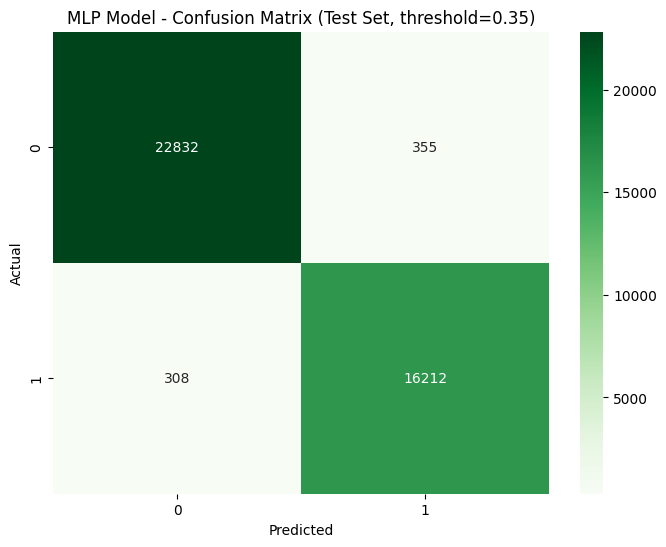

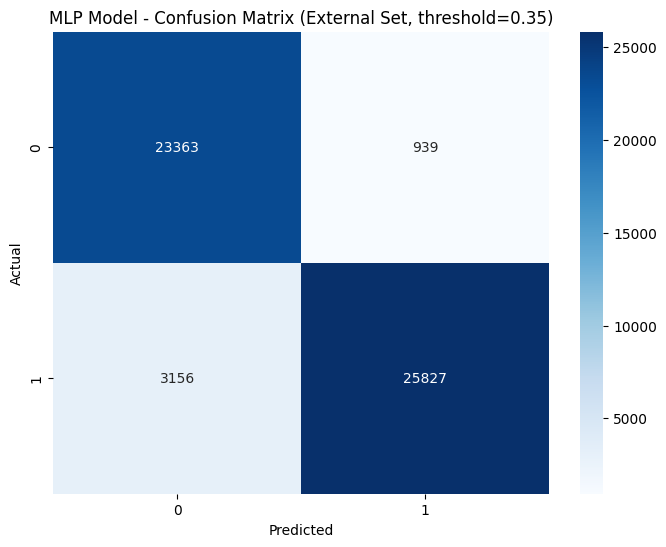

In [ ]:
# AGGRESSIVE: Use lower threshold for phishing classification
phishing_threshold = config['phishing_threshold']
print(f"\n Using phishing threshold: {phishing_threshold} (default is 0.5)")

# Evaluate MLP on test set
mlp_model.eval()
test_preds = []
test_labels = []
test_probs = []

with torch.no_grad():
    for embeddings, features, labels in test_loader:
        embeddings, features = embeddings.to(device), features.to(device)
        
        logits = mlp_model(embeddings, features).squeeze()
        probs = torch.sigmoid(logits)
        
        # Handle both batch and single samples
        if probs.dim() == 0:
            test_probs.append(probs.cpu().item())
            test_labels.append(labels.item())
        else:
            test_probs.extend(probs.cpu().numpy())
            test_labels.extend(labels.numpy())

test_probs = np.array(test_probs)
test_labels = np.array(test_labels)
test_preds = (test_probs >= phishing_threshold).astype(int)  # AGGRESSIVE threshold

mlp_test_metrics = {
    'accuracy': accuracy_score(test_labels, test_preds),
    'precision': precision_score(test_labels, test_preds, zero_division=0),
    'recall': recall_score(test_labels, test_preds, zero_division=0),
    'f1': f1_score(test_labels, test_preds, zero_division=0),
    'roc_auc': roc_auc_score(test_labels, test_probs)
}

print(f"\nMLP Test Set Metrics (threshold={phishing_threshold}):")
for metric, value in mlp_test_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Evaluate on external set
external_dataset = TensorDataset(
    torch.FloatTensor(X_emb_external),
    torch.FloatTensor(features_external),
    torch.FloatTensor(y_external)
)
external_loader = DataLoader(external_dataset, batch_size=config["mlp_batch_size"], shuffle=False)

ext_preds = []
ext_labels = []
ext_probs = []

with torch.no_grad():
    for embeddings, features, labels in external_loader:
        embeddings, features = embeddings.to(device), features.to(device)
        
        logits = mlp_model(embeddings, features).squeeze()
        probs = torch.sigmoid(logits)
        
        # Handle both batch and single samples
        if probs.dim() == 0:
            ext_probs.append(probs.cpu().item())
            ext_labels.append(labels.item())
        else:
            ext_probs.extend(probs.cpu().numpy())
            ext_labels.extend(labels.numpy())

ext_probs = np.array(ext_probs)
ext_labels = np.array(ext_labels)
ext_preds = (ext_probs >= phishing_threshold).astype(int)  # AGGRESSIVE threshold

mlp_external_metrics = {
    'accuracy': accuracy_score(ext_labels, ext_preds),
    'precision': precision_score(ext_labels, ext_preds, zero_division=0),
    'recall': recall_score(ext_labels, ext_preds, zero_division=0),
    'f1': f1_score(ext_labels, ext_preds, zero_division=0),
    'roc_auc': roc_auc_score(ext_labels, ext_probs)
}

print(f"\nMLP External Set Metrics (threshold={phishing_threshold}):")
for metric, value in mlp_external_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Log to WandB
wandb.log({
    "mlp/phishing_threshold": phishing_threshold,
    "mlp/pos_weight": config['class_weight_ratio'],
    "mlp/test_accuracy": mlp_test_metrics['accuracy'],
    "mlp/test_precision": mlp_test_metrics['precision'],
    "mlp/test_recall": mlp_test_metrics['recall'],
    "mlp/test_f1": mlp_test_metrics['f1'],
    "mlp/test_roc_auc": mlp_test_metrics['roc_auc'],
    "mlp/external_accuracy": mlp_external_metrics['accuracy'],
    "mlp/external_precision": mlp_external_metrics['precision'],
    "mlp/external_recall": mlp_external_metrics['recall'],
    "mlp/external_f1": mlp_external_metrics['f1'],
    "mlp/external_roc_auc": mlp_external_metrics['roc_auc'],
})

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'MLP Model - Confusion Matrix (Test Set, threshold={phishing_threshold})')
wandb.log({"mlp/confusion_matrix": wandb.Image(fig)})
plt.show()

cm = confusion_matrix(ext_labels, ext_preds)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'MLP Model - Confusion Matrix (External Set, threshold={phishing_threshold})')
wandb.log({"mlp/confusion_matrix": wandb.Image(fig)})
plt.show()
plt.close()

## 10. Compare Model Performance

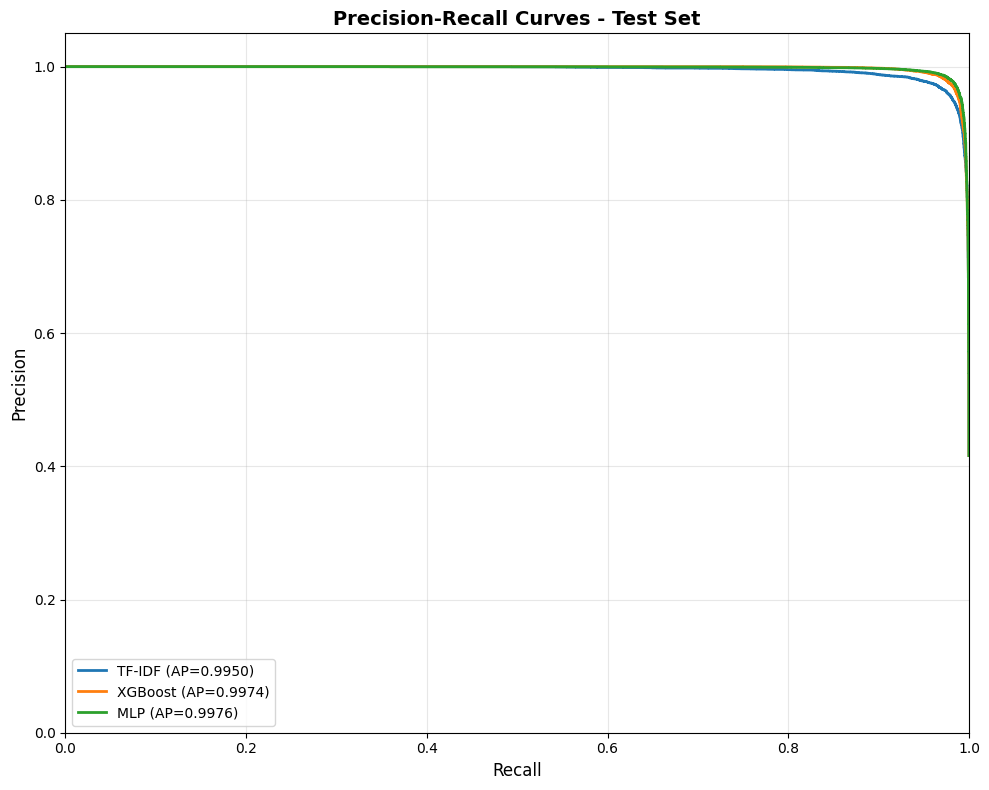

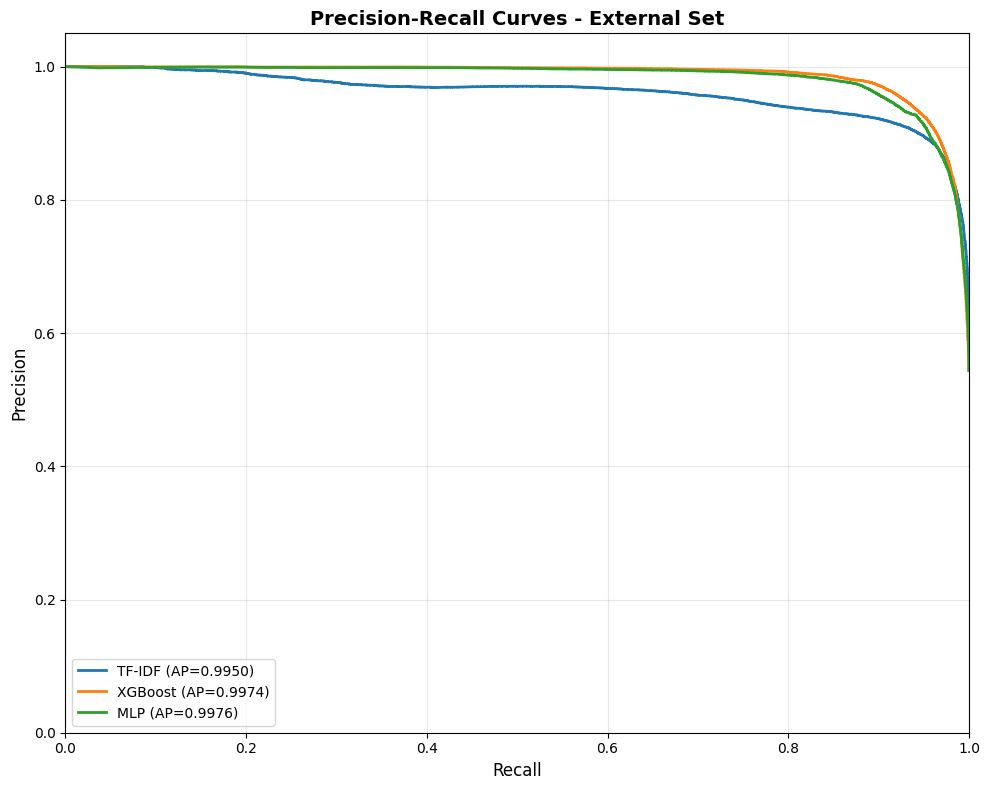


TEST SET PERFORMANCE:
Model                Accuracy     Precision    Recall       F1           ROC-AUC     
--------------------------------------------------------------------------------
TF-IDF + LogReg      0.9555       0.9093       0.9920       0.9488       0.9963      
XGBoost Hybrid       0.9784       0.9638       0.9851       0.9743       0.9979      
MLP Hybrid           0.9833       0.9786       0.9814       0.9800       0.9980      

EXTERNAL VALIDATION SET PERFORMANCE:
Model                Accuracy     Precision    Recall       F1           ROC-AUC     
--------------------------------------------------------------------------------
TF-IDF + LogReg      0.9126       0.8956       0.9500       0.9220       0.9616      
XGBoost Hybrid       0.9345       0.9551       0.9229       0.9387       0.9818      
MLP Hybrid           0.9231       0.9649       0.8911       0.9265       0.9790      


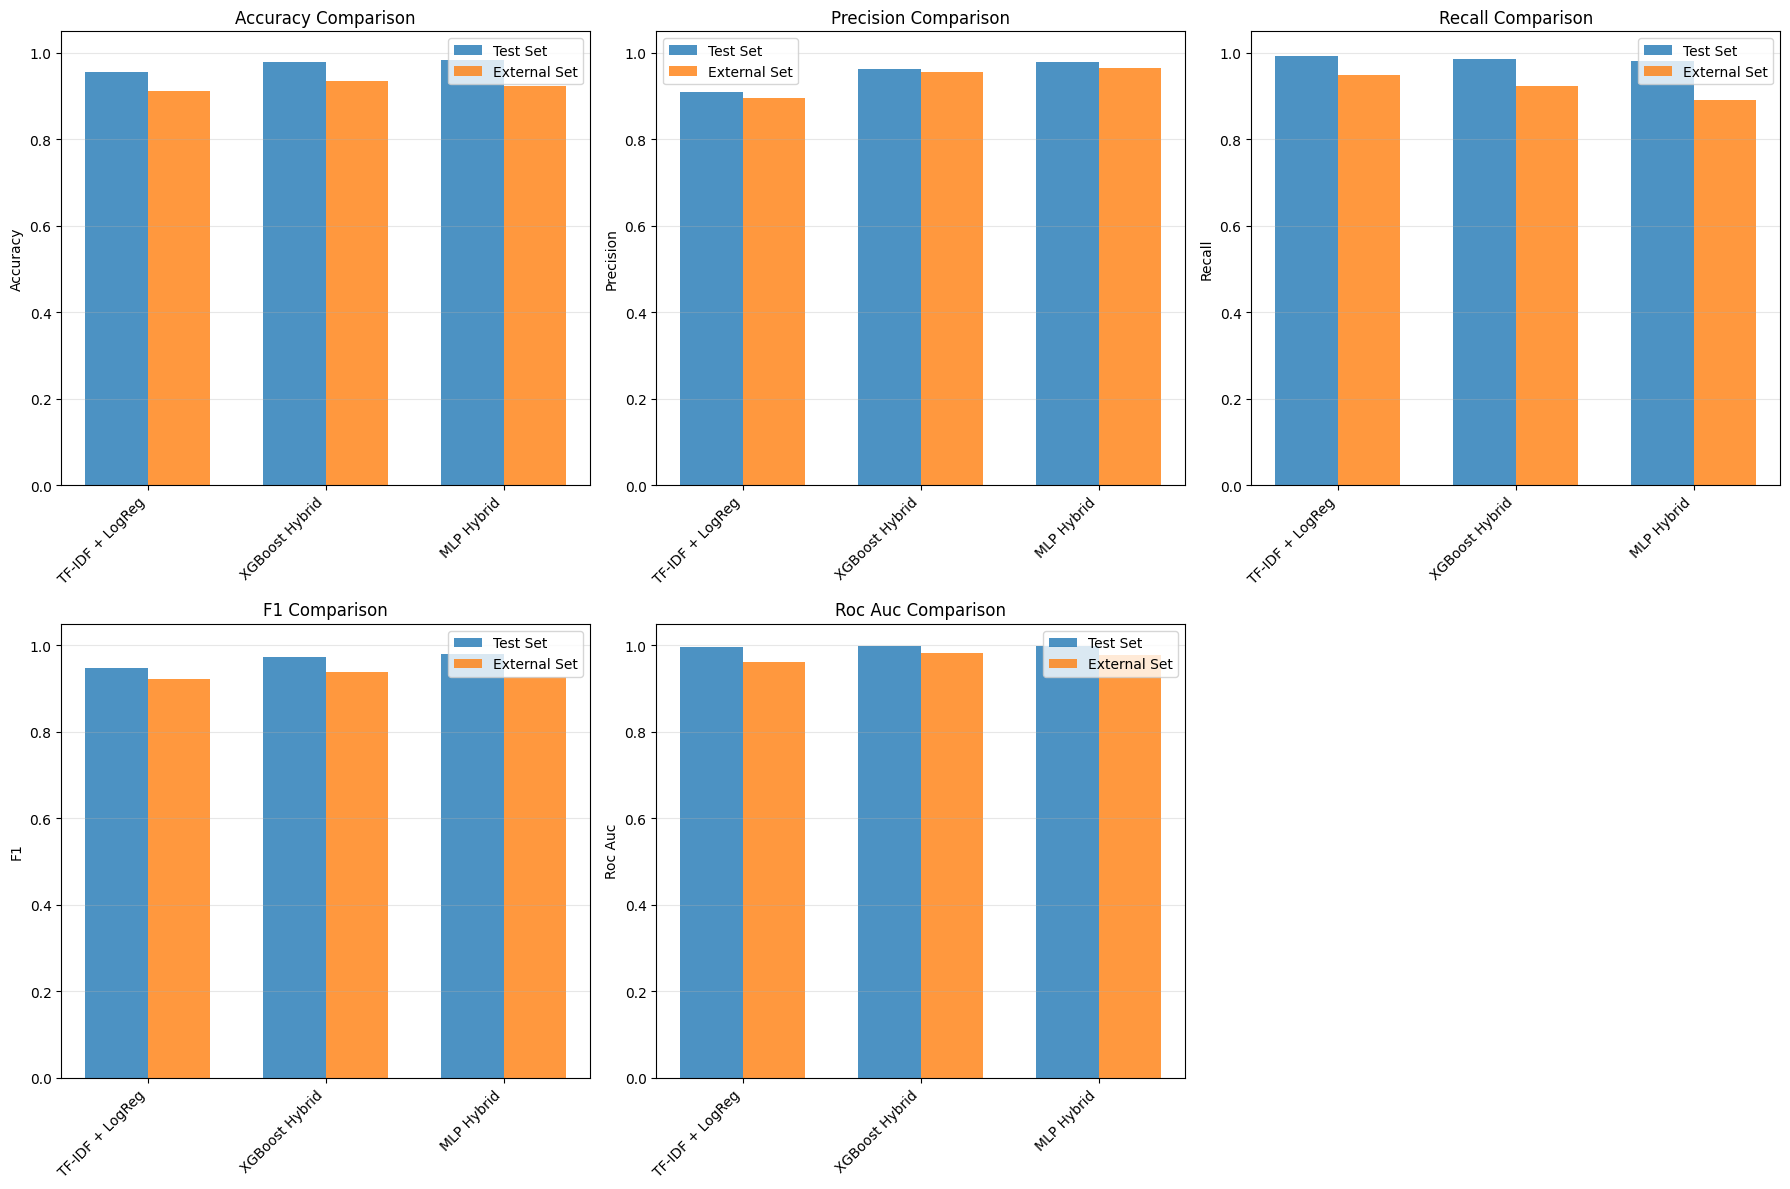

In [ ]:
# Create comprehensive comparison
comparison_data = {
    'TF-IDF + LogReg': {
        'test': tfidf_test_metrics,
        'external': tfidf_external_metrics
    },
    'XGBoost Hybrid': {
        'test': xgb_test_metrics,
        'external': xgb_external_metrics
    },
    'MLP Hybrid': {
        'test': mlp_test_metrics,
        'external': mlp_external_metrics
    }
}

from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate PR curves
tfidf_precision_test, tfidf_recall_test, _ = precision_recall_curve(y_test, y_proba_test_tfidf)
xgb_precision_test, xgb_recall_test, _ = precision_recall_curve(y_test, y_proba_test_xgb)
mlp_precision_test, mlp_recall_test, _ = precision_recall_curve(test_labels, test_probs)

tfidf_precision_ex, tfidf_recall_ex, _ = precision_recall_curve(y_external, y_proba_ext_tfidf)
xgb_precision_ex, xgb_recall_ex, _ = precision_recall_curve(y_external, y_proba_ext_xgb)
mlp_precision_ex, mlp_recall_ex, _ = precision_recall_curve(ext_labels, ext_probs)


# Calculate average precision
tfidf_ap = average_precision_score(y_test, y_proba_test_tfidf)
xgb_ap = average_precision_score(y_test, y_proba_test_xgb)
mlp_ap = average_precision_score(test_labels, test_probs)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(tfidf_recall_test, tfidf_precision_test, label=f'TF-IDF (AP={tfidf_ap:.4f})', linewidth=2)
ax.plot(xgb_recall_test, xgb_precision_test, label=f'XGBoost (AP={xgb_ap:.4f})', linewidth=2)
ax.plot(mlp_recall_test, mlp_precision_test, label=f'MLP (AP={mlp_ap:.4f})', linewidth=2)
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curves - Test Set', fontsize=14, fontweight='bold')
ax.legend(loc='lower left', fontsize=10)
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.05])

plt.tight_layout()
wandb.log({"comparison/pr_curves": wandb.Image(fig)})
plt.show()
plt.close()

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(tfidf_recall_ex, tfidf_precision_ex, label=f'TF-IDF (AP={tfidf_ap:.4f})', linewidth=2)
ax.plot(xgb_recall_ex, xgb_precision_ex, label=f'XGBoost (AP={xgb_ap:.4f})', linewidth=2)
ax.plot(mlp_recall_ex, mlp_precision_ex, label=f'MLP (AP={mlp_ap:.4f})', linewidth=2)
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curves - External Set', fontsize=14, fontweight='bold')
ax.legend(loc='lower left', fontsize=10)
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.05])

plt.tight_layout()
wandb.log({"comparison/pr_curves": wandb.Image(fig)})
plt.show()
plt.close()

# Test set comparison
print("\nTEST SET PERFORMANCE:")
print(f"{'Model':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1':<12} {'ROC-AUC':<12}")
print("-" * 80)
for model_name, metrics in comparison_data.items():
    test_m = metrics['test']
    print(f"{model_name:<20} {test_m['accuracy']:<12.4f} {test_m['precision']:<12.4f} "
          f"{test_m['recall']:<12.4f} {test_m['f1']:<12.4f} {test_m['roc_auc']:<12.4f}")

# External set comparison
print("\nEXTERNAL VALIDATION SET PERFORMANCE:")
print(f"{'Model':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1':<12} {'ROC-AUC':<12}")
print("-" * 80)
for model_name, metrics in comparison_data.items():
    ext_m = metrics['external']
    print(f"{model_name:<20} {ext_m['accuracy']:<12.4f} {ext_m['precision']:<12.4f} "
          f"{ext_m['recall']:<12.4f} {ext_m['f1']:<12.4f} {ext_m['roc_auc']:<12.4f}")

# Create comparison visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for idx, metric in enumerate(metrics_to_plot):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    models = list(comparison_data.keys())
    test_values = [comparison_data[m]['test'][metric] for m in models]
    external_values = [comparison_data[m]['external'][metric] for m in models]
    
    x = np.arange(len(models))
    width = 0.35
    
    ax.bar(x - width/2, test_values, width, label='Test Set', alpha=0.8)
    ax.bar(x + width/2, external_values, width, label='External Set', alpha=0.8)
    
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(f'{metric.replace("_", " ").title()} Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend()
    ax.set_ylim([0, 1.05])
    ax.grid(axis='y', alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[1, 2])

plt.tight_layout()
wandb.log({"comparison/metrics_comparison": wandb.Image(fig)})
plt.show()

comparison_table_data = []
for model_name, metrics in comparison_data.items():
    for split, split_metrics in metrics.items():
        row = [model_name, split] + [split_metrics[m] for m in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']]
        comparison_table_data.append(row)

comparison_table = wandb.Table(
    columns=['Model', 'Split', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC'],
    data=comparison_table_data
)
wandb.log({"comparison/performance_table": comparison_table})


## 11. Save Models and Artifacts


In [ ]:
# Create directories
os.makedirs("../../output/saved_models", exist_ok=True)
os.makedirs("../../output/saved_artifacts", exist_ok=True)

print("Saving models and artifacts...")

with open('../../output/saved_models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
with open('../../output/saved_models/tfidf_classifier.pkl', 'wb') as f:
    pickle.dump(lr_clf, f)

xgb_clf.save_model('../../output/saved_models/xgboost_hybrid.json')

torch.save({
    'model_state_dict': mlp_model.state_dict(),
    'embedding_dim': config["embedding_dim"],
    'num_features': len(numeric_features),
    'feature_hidden_dim': config["mlp_feature_hidden_dim"],
    'dropout': config["mlp_dropout"],
    'test_metrics': mlp_test_metrics,
    'external_metrics': mlp_external_metrics,
    'phishing_threshold': config['phishing_threshold'],  # AGGRESSIVE: Save threshold
    'class_weight_ratio': config['class_weight_ratio']   # AGGRESSIVE: Save class weight
}, '../../output/saved_models/mlp_hybrid.pth')

# Save experiment configuration
full_config = {
    'experiment_config': config,
    'aggressive_settings': {
        'phishing_threshold': config['phishing_threshold'],
        'class_weight_ratio': config['class_weight_ratio'],
        'description': 'Models trained with aggressive phishing detection - lower threshold and higher penalties for False Negatives'
    },
    'data_splits': {
        'train_size': len(train_df),
        'test_size': len(test_df),
        'external_size': len(external_df)
    },
    'model_performance': {
        'tfidf': {
            'test': {k: float(v) for k, v in tfidf_test_metrics.items()},
            'external': {k: float(v) for k, v in tfidf_external_metrics.items()}
        },
        'xgboost': {
            'test': {k: float(v) for k, v in xgb_test_metrics.items()},
            'external': {k: float(v) for k, v in xgb_external_metrics.items()}
        },
        'mlp': {
            'test': {k: float(v) for k, v in mlp_test_metrics.items()},
            'external': {k: float(v) for k, v in mlp_external_metrics.items()}
        }
    },
    'feature_names': numeric_features,
    'timestamp': datetime.now().isoformat()
}

with open('../../output/saved_artifacts/experiment_config.json', 'w') as f:
    json.dump(full_config, f, indent=2)

print("\nSaved aggressive phishing detection settings:")
print(f"   - Threshold: {config['phishing_threshold']}")
print(f"   - Class Weight Ratio: {config['class_weight_ratio']}")

# Upload artifacts to WandB
artifact = wandb.Artifact('phishstop-models-aggressive', type='model')
artifact.add_dir('../../output/saved_models')
artifact.add_file('../../output/saved_artifacts/experiment_config.json')
wandb.log_artifact(artifact)



wandb: Adding directory to artifact (..\..\output\saved_models)... 

Saving models and artifacts...

Saved aggressive phishing detection settings:
   - Threshold: 0.35
   - Class Weight Ratio: 3.0


Done. 0.1s


<Artifact phishstop-models-aggressive>

In [ ]:
# Finish WandB run
wandb.finish()
print("✓ WandB run completed")

best_iteration,▁
best_score,▁
class_balance,▁
embedding_dim,▁
epoch,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
external_phishing_ratio,▁
external_size,▁
legit_count,▁
mlp/epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
mlp/external_accuracy,▁
+49,...


✓ WandB run completed
